In [ ]:
from notebooks import *
print_sys_info()

platform:
  machine: x86_64
  node: a104319b04ef
  processor: x86_64
  release: 4.14.33+
  system: Linux
  version: '#1 SMP Wed Jun 20 01:15:52 PDT 2018'
cpu: 96
mem: 85g
swap: 0g


In [ ]:
# Load models
load = Load()
projection = Projection.load('peterson-v0-26bae1c', features=Features(load=load))

[20:28:43.386] DEBUG  Projection.load
  path: /app/data/models/projection/peterson-v0-26bae1c.pkl


In [ ]:
# Select recs
#   1. countries: Filter recs to these countries
#   2. species: Filter recs to these species
#   3. recs_at_least: Filter species to those with at least this many recs
#   4. num_species: Sample this many of the species
#   5. num_recs: Sample this many recs per species
inf = np.inf
# countries_k, com_names_k = 'na', 'us'      # 9.4k/400k -> 1.1k/60k -> 774/53k
countries_k, com_names_k = 'na', 'ca'      # 9.4k/400k -> 1.1k/60k -> 334/35k
# countries_k, com_names_k = 'na', 'dan170'  # 9.4k/400k -> 1.1k/60k -> 170/24k
recs_at_least, num_species, num_recs =   0, inf, inf  # US[334/35k ->1.1k/60k -> 774/53k -> 774/53k   -> 743/53k]    # All US
# recs_at_least, num_species, num_recs = 100, 100, 100  # CA[334/35k -> 127/25k -> 100/21k -> 100/10k   -> 100/10k]
# recs_at_least, num_species, num_recs =  50, 100, 100  # CA[334/35k -> 224/32k -> 100/16k -> 100/ 9.0k -> 100/ 9.0k]
# recs_at_least, num_species, num_recs =   0, 100, 100  # CA[334/35k -> 334/35k -> 100/12k -> 100/ 6.8k ->  99/ 6.8k]
# recs_at_least, num_species, num_recs =   0, 168, 100  # CA[334/34k -> 334/34k -> 168/18k -> 168/11k   -> 167/11k]    # (old 'all')
# recs_at_least, num_species, num_recs =   0, 168,  20  # CA[334/34k -> 334/35k -> 168/18k -> 168/ 3.2k -> 167/ 3.2k]  # (old 'recs')
# recs_at_least, num_species, num_recs =  20, 168,  20  # CA[334/35k -> 296/35k -> 168/20k -> 168/ 3.4k -> 168/ 3.4k]  # Familiar set
# recs_at_least, num_species, num_recs =  20, 336,  20  # US[774/53k -> 528/51k -> 336/33k -> 336/ 6.7k -> 336/ 6.7k]  # Scale species
# recs_at_least, num_species, num_recs =  10, 168,  20  # CA[334/35k ->                                             ]  # Class imbalance
# recs_at_least, num_species, num_recs =   0, 168,  20  # CA[334/35k ->                                             ]  # Class imbalance
# recs_at_least, num_species, num_recs =  20, 50,  100  # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,   50  # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,   20  # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,   10  # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,    5  # Faster dev
get_recs_stats = lambda df: dict(sp=df.species.nunique(), recs=len(df))
puts_stats = lambda desc: partial(tap, f=lambda df: print('%-15s %12s (sp/recs)' % (desc, '%(sp)s/%(recs)s' % get_recs_stats(df))))
xcs = (xc.metadata
    .pipe(puts_stats('all'))
    # 1. countries: Filter recs to these countries
    [lambda df: df.country.isin(constants.countries[countries_k])]
    .pipe(puts_stats('countries'))
    # 2. species: Filter recs to these species
    [lambda df: df.species.isin(com_names_to_species(*com_names[com_names_k]))]
    .pipe(puts_stats('species'))
    # Omit not-downloaded recs (should be few within the selected countries)
    [lambda df: df.downloaded]
    .pipe(puts_stats('(downloaded)'))
    # Remove empty cats for perf
    .pipe(df_remove_unused_categories)
    # 3. recs_at_least: Filter species to those with at least this many recs
    [lambda df: df.species.isin(df.species.value_counts()[lambda s: s >= recs_at_least].index)]
    .pipe(puts_stats('recs_at_least'))
    # 4. num_species: Sample this many of the species
    [lambda df: df.species.isin(df.species.drop_duplicates().pipe(lambda s: s.sample(n=min(len(s), num_species), random_state=0)))]
    .pipe(puts_stats('num_species'))
    # 5. num_recs: Sample this many recs per species
    #   - Remove empty cats else .groupby fails on empty groups
    .pipe(df_remove_unused_categories)
    .groupby('species').apply(lambda g: g.sample(n=min(len(g), num_recs), random_state=0))
    .pipe(puts_stats('num_recs'))
    # Drop species with <2 recs, else StratifiedShuffleSplit complains (e.g. 'TUVU')
    [lambda df: df.species.isin(df.species.value_counts()[lambda s: s >= 2].index)]
    .pipe(puts_stats('recs ≥ 2'))
    # Clean up for downstream
    .pipe(df_remove_unused_categories)
)
_recs_stats = get_recs_stats(xcs)
recs_stats = ', '.join(['%s[%s]' % (k, v) for k, v in _recs_stats.items()])
display(
    recs_stats,
    df_summary(xcs).T,
    xcs.sample(n=10, random_state=0).sort_values('species'),
)

all              9442/399859 (sp/recs)
countries         1148/59713 (sp/recs)
species            334/35237 (sp/recs)
(downloaded)       334/35229 (sp/recs)
recs_at_least      334/35229 (sp/recs)
num_species        334/35229 (sp/recs)


num_recs           334/35229 (sp/recs)
recs ≥ 2           331/35226 (sp/recs)


'sp[331], recs[35226]'

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
downloaded,bool,986328,35226,35226,1,NaN,NaN,True,True,True,True,True
species,category,1866988,35226,35226,331,NaN,NaN,SNGO,LEFL,CAGN,FOSP,PTWH
id,int64,986328,35226,35226,35226,219189.394,110898.575,584,135962,207428,320709,417729
sci_name,category,2363389,35226,35226,332,NaN,NaN,Chen caerulescens,Empidonax minimus,Polioptila californica,Passerella iliaca,Vidua macroura
com_name,category,2290009,35226,35226,332,NaN,NaN,Snow Goose,Least Flycatcher,California Gnatcatcher,Fox Sparrow,Pin-tailed Whydah
subspecies,object,1794442,35226,35226,715,NaN,NaN,,,,,zelotes
recordist,object,2227328,35226,35226,751,NaN,NaN,AJ Knue,Frank Lambert,Matt Wistrand,Richard E Webster,Étienne Leroy
country,object,2123560,35226,35226,3,NaN,NaN,Canada,United States,United States,United States,United States
locality,object,3318927,35226,35226,6444,NaN,NaN,"Bangor City Forest, Penobscot County, Maine","Durfee Hill, Glocester, Providence County, Rhode Island","Merritt Square Mall, Merritt Island, Brevard County, Florida","Round Valley, Chiricahua Mountains, Cochise Co., Arizona","Álvaro Obregón (near Ciudad de México), Ciudad de México"


,,downloaded,species,id,sci_name,com_name,subspecies,recordist,country,locality,lat,lng,type,quality,date,time,license_type,license_detail,license,url,download
species,,,,,,,,,,,,,,,,,,,,,
SPOW,33738,True,SPOW,383310,Strix occidentalis,Spotted Owl,occidentalis,Lance A. M. Benner,United States,"Red Box to Valley Forge Campground, Angeles National Forest, Los Angeles County, California",34.3,-118.0,"call, female",no score,2017-08-05 00:00:00,20:33,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/383310,//www.xeno-canto.org/383310/download
WBNU,334163,True,WBNU,72056,Sitta carolinensis,White-breasted Nuthatch,alexandrae,Richard E Webster,Mexico,"La Corona Arriba, Sierra San Pedro Martir, Baja California",31.0,-116.0,call,C,2010-09-25 00:00:00,0824,by-nc-nd,2.5,//creativecommons.org/licenses/by-nc-nd/2.5/,https://www.xeno-canto.org/72056,//www.xeno-canto.org/72056/download
WOTH,369818,True,WOTH,33467,Hylocichla mustelina,Wood Thrush,,Andrew Spencer,United States,"Steel Creek, Buffalo National River, Madison Co., Arkansas",36.0,-93.3,song,A,2009-04-26 00:00:00,07:35,by-nc-nd,2.5,//creativecommons.org/licenses/by-nc-nd/2.5/,https://www.xeno-canto.org/33467,//www.xeno-canto.org/33467/download
CATH,288038,True,CATH,121010,Toxostoma redivivum,California Thrasher,,Lance A. M. Benner,United States,"Powder Canyon, Puente Hills, Los Angeles County, California",34.0,-118.0,song,B,2013-02-02 00:00:00,11:49,by-nc-sa,3.0,//creativecommons.org/licenses/by-nc-sa/3.0/,https://www.xeno-canto.org/121010,//www.xeno-canto.org/121010/download
GRWA,92364,True,GRWA,323600,Setophaga graciae,Grace's Warbler,graciae,Richard E. Webster,United States,"Rucker Canyon, Chiricahua Mountains",31.8,-109.0,song,B,2015-05-30 00:00:00,19:00,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/323600,//www.xeno-canto.org/323600/download
BCSP,283513,True,BCSP,125726,Spizella atrogularis,Black-chinned Sparrow,cana,Richard E. Webster,United States,"Arrastre Creek at 2N02, San Bernardino Mountains, California",34.3,-117.0,song,A,2006-05-05 00:00:00,09:00,by-nc-sa,3.0,//creativecommons.org/licenses/by-nc-sa/3.0/,https://www.xeno-canto.org/125726,//www.xeno-canto.org/125726/download
BTSP,297229,True,BTSP,111342,Amphispiza bilineata,Black-throated Sparrow,deserticola,Richard E Webster,United States,"Silver Creek, Cave Creek Canyon, Cochise County, Arizona",31.9,-109.0,subsong,A,2010-09-09 00:00:00,07:37,by-nc-nd,2.5,//creativecommons.org/licenses/by-nc-nd/2.5/,https://www.xeno-canto.org/111342,//www.xeno-canto.org/111342/download
GTTO,296563,True,GTTO,112024,Pipilo chlorurus,Green-tailed Towhee,,Richard E Webster,United States,"Round Valley, Chiricahua Mountains, Cochise Co., Arizona",32.0,-109.0,"call, song",A,2008-09-29 00:00:00,08:35,by-nc-nd,2.5,//creativecommons.org/licenses/by-nc-nd/2.5/,https://www.xeno-canto.org/112024,//www.xeno-canto.org/112024/download
BHGR,135981,True,BHGR,278681,Pheucticus melanocephalus,Black-headed Grosbeak,,Nick Komar,United States,"Patagonia Roadside Rest Area, Patagonia, AZ",31.5,-111.0,"begging call, juvenile",C,2015-09-08 00:00:00,09:15,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/278681,//www.xeno-canto.org/278681/download


In [ ]:
xcs_paths = [
    ('xc', f'{data_dir}/xc/data/{row.species}/{row.id}/audio.mp3')
    for row in df_rows(xcs)
]
joblib.dump(xcs_paths, '/tmp/xcs_paths')  # In case you want to run load.recs in a terminal (it's long and verbose)
display(
    f"{len(xcs_paths)}/{len(xcs)}",
    # xcs_paths[:2],
)

'35226/35226'

In [ ]:
# TODO Restore once:true after debug [but think carefully how once:true interacts with the once:false params above]
recs = load.recs(paths=xcs_paths)
display(
    df_summary(recs).T,
    recs[:5],
)

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
dataset,object,1795506,35206,35206,1,NaN,NaN,xc,xc,xc,xc,xc
species,category,1865928,35206,35206,331,NaN,NaN,SNGO,LEFL,CAGN,FOSP,PTWH
species_com_name,category,2284340,35206,35206,331,NaN,NaN,Snow Goose,Least Flycatcher,California Gnatcatcher,Fox Sparrow,Pin-tailed Whydah
species_query,object,1865928,35206,35206,331,NaN,NaN,ABTO,CONI,LEGO,SACR,yecpar
duration_s,float64,844944,35206,35206,21247,5.711e+01,7.221e+01,0.209,16.6,35,69.1,2.75e+03
samples_mb,float64,844944,35206,35206,21236,2.417e+00,3.070e+00,0.00879,0.7,1.47,2.92,115
samples_n,int64,985768,35206,35206,21236,1.267e+06,1.610e+06,4608,367030,772992,1533092,60534352
basename,object,1901124,35206,35206,1,NaN,NaN,audio,audio,audio,audio,audio
species_longhand,category,2530792,35206,35206,331,NaN,NaN,Snow Goose - SNGO,Least Flycatcher - LEFL,California Gnatcatcher - CAGN,Fox Sparrow - FOSP,Pin-tailed Whydah - PTWH


,dataset,species,species_com_name,species_query,duration_s,samples_mb,samples_n,basename,species_longhand,id,path
0,xc,SNGO,Snow Goose,SNGO,28.3,1.19,624456,audio,Snow Goose - SNGO,xc/data/SNGO/143620/audio,xc/data/SNGO/143620/audio.mp3
1,xc,SNGO,Snow Goose,SNGO,149.0,6.28,3293022,audio,Snow Goose - SNGO,xc/data/SNGO/298775/audio,xc/data/SNGO/298775/audio.mp3
2,xc,SNGO,Snow Goose,SNGO,21.6,0.91,476928,audio,Snow Goose - SNGO,xc/data/SNGO/116051/audio,xc/data/SNGO/116051/audio.mp3
3,xc,SNGO,Snow Goose,SNGO,44.6,1.88,983275,audio,Snow Goose - SNGO,xc/data/SNGO/392249/audio,xc/data/SNGO/392249/audio.mp3
4,xc,SNGO,Snow Goose,SNGO,148.0,6.23,3267214,audio,Snow Goose - SNGO,xc/data/SNGO/357958/audio,xc/data/SNGO/357958/audio.mp3


In [ ]:
# Fast-and-cheap version (<1s) of the plots below (~7s)
(recs
    .species_longhand.value_counts().sort_index()
    .reset_index().rename(columns={'index': 'species_longhand', 'species_longhand': 'num_recs'})
    .assign(num_recs=lambda df: df.num_recs.map(lambda n: '%s /%s' % ('•' * int(n / df.num_recs.max() * 60), df.num_recs.max())))
)

,species_longhand,num_recs
0,Snow Goose - SNGO,••••• /659
1,Greater White-fronted Goose - GWFG,••• /659
2,Brant - BRAN,•• /659
3,Cackling Goose - CACG,••• /659
4,Canada Goose - CANG,•••••••••• /659
5,Tundra Swan - TUSW,•• /659
6,Egyptian Goose - EGGO,/659
7,Cinnamon Teal - CITE,/659
8,Gadwall - GADW,•• /659
9,American Wigeon - AMWI,••• /659


In [ ]:
# Num recs loaded for training + total num available [slow: ~7s]
(recs
    .pipe(df_reverse_cat, 'species_longhand')
    .assign(recs_n=1).groupby(['species', 'species_longhand'])['recs_n'].sum().reset_index()
    .set_index('species')
    # [:100]
    .join(how='left', other=(xc.metadata
        .assign(total_n=1).groupby('species')['total_n'].sum().reset_index()
        .set_index('species')
    ))
    .reset_index()
    .pipe(ggplot)
    + aes(x='species_longhand')
    + geom_col(aes(y='total_n'), fill='darkgray')
    + geom_col(aes(y='recs_n'), fill=scale_color_cmap(mpl.cm.tab10).palette(0))
    # + geom_point(aes(y='total_n'), color='darkgray')
    # + geom_point(aes(y='recs_n'), color=scale_color_cmap(mpl.cm.tab10).palette(0))
    + expand_limits(y=0)
    + coord_flip()
    + theme(axis_text_y=element_text(size=4))
    + theme_figsize(width=18, aspect_ratio=3/2)
    + ggtitle('Num recs loaded for training + total num available')
)

[skip]

In [ ]:
# Plot recs with duration [slow: ~7s]
(recs
    .assign(species=lambda df: df.species_longhand)
    .assign(count=1)
    # 0-fill all (species, dataset) combinations to create empty placeholders for missing bars
    .pipe(lambda df: df.append(
        pd.DataFrame([
            dict(species=species, dataset=dataset, duration_s=0)
            for species in df.species.unique()
            for dataset in df.dataset.unique()
        ])
        .astype({'species': df.species.dtype})
    ))
    .groupby(['dataset', 'species'])[['count', 'duration_s']].sum().reset_index()
    # Order by species by taxo
    .pipe(df_reverse_cat, 'species')
    # Order by species by count
    # .pipe(df_ordered_cat, species=lambda df: df.sort_values('count').species)
    .pipe(pd.melt, id_vars=['dataset', 'species'], value_vars=['count', 'duration_s'])
    .pipe(df_remove_unused_categories)
    .pipe(ggplot, aes(x='species', y='value', fill='dataset', color='dataset'))
    + coord_flip()
    + geom_bar(stat='identity', position=position_dodge(), width=.8)
    + facet_wrap('variable', nrow=1, scales='free')
    + xlab('')
    + ylab('')
    + scale_fill_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + scale_color_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + theme(panel_spacing=2.5)
    + theme_figsize(width=18, aspect_ratio=4/1)
    + ggtitle(f'recs: Total (count, duration_s) per (species, dataset)')
)

[skip]

In [ ]:
# Add .feat
recs = projection.transform(recs)

In [ ]:
# GridSearchCV many models / model params
#   - Order these roughly from most to least expensive, so that training runs fail fast (e.g. oom at the start, not the end)
param_grid = list(unique_everseen(tqdm([
    dict(
        classifier=[classifier],
        n_species=[n_species if isinstance(n_species, int) else int(n_species * _recs_stats['sp'])],
        n_recs=[
            # n_recs if isinstance(n_recs, int) else int(n_recs * _recs_stats['recs']),
            # TODO Figure out how to represent this as an n instead of a frac again [TODO interaction with test_size=.2 ...]
            #   - TODO Also make clear in the plot descs when e.g. (recs[3360], n_species[33], n_recs[1.0]) -> n_recs[33*20 < 3360]
            n_recs,
        ],
    )
    for (n_species, n_recs) in [
        # Subset for learning curves
        #   - Biggest first, to fail fast

        # (None, None),

        # Quick wins
        # (0.01, 0.01),

        # TODO TODO n_species[10] for quick model comps
        (0.03, 0.03),  # ~1000 recs in the train split
        (0.03, 0.25),
        # (0.03, 0.50),

        # Scale data for n_species[86]
        # (0.25, 0.25),
        # (0.25, 0.50),
        # (0.25, 1.00),

        # # Scale data for n_species[165]
        # (0.50, 0.25),
        # (0.50, 0.50),
        # (0.50, 1.00),

        # # Scale data for n_species[331]
        # (1.00, 0.25),
        # (1.00, 0.50),
        # (1.00, 1.00),

        # # Scale species for n_recs[1]
        # (0.25, 1.00),
        # (0.50, 1.00),
        # (1.00, 1.00),

        # (1.00, 1.00),
        # (1.00, 0.50),
        # (0.50, 1.00),

        # Faster dev
        # (0.10, 0.10),

    ]
    # model_size ~ forest_depth
    for rf_max_depth in [
        'null',
        1, 2, 3, 4, 5,
        12, 25, 50, 100,
        # 12, 25, 33, 50, 75, 100,
    ]
    # for ovr_rf_max_depth in [int(rf_max_depth / 10) if rf_max_depth != 'null' else 'null']
    # for xgb_rf_max_depth in [lambda x: x if x != 'null' else 100]
    for ovr_rf_max_depth in [
        # 'null',
        # 46,  # TODO TODO Got 1 with n_est=100 -- after 8h x 32 cores!
        # 35,  # TODO TODO Giving up on this one
        # 12, 25, 33, 50, 75, 100,  # WARNING See previous lines
        1, 2, 3, 4, 5,
        # 1, 2, 3,
    ]
    for xgb_rf_max_depth_f in [lambda x: x if x != 'null' else 100]
    for xgb_rf_max_depth in [
        # xgb_rf_max_depth_f(rf_max_depth),
        xgb_rf_max_depth_f(ovr_rf_max_depth),
    ]
    for rf_n_estimators in [
        # 2000, 1500,  # WARNING Not mem safe on laptop
        100, 200, 400,
        # 50, 25,  # TODO Train
    ]
    for xgb_rf_n_estimators in [
        # 1600,  # TODO TODO Took 8h x 32 cores to get (n_est=100, max_depth=46), giving up on n_est=1600
        100, 200, 400,
        # 25, 50,
    ]
    for ovr_rf_n_estimators in [
        100,
        # 50, 25,
    ]
    for logreg_cls, logreg_solver in [
        ('logreg_ovr', 'liblinear'),  # 1 core
        ('logreg_ovr_std', 'liblinear'),  # 1 core
        ('logreg_ovr', 'saga'),  # ~5 cores
        ('logreg_ovr_std', 'saga'),  # ~5 cores
        ('logreg_ovr', 'sag'),  # ~5 cores
        ('logreg_ovr_std', 'sag'),  # ~5 cores
        # ('logreg_ovr', 'lbfgs'),  # ≥96 cores
        # ('logreg_ovr', 'newton-cg'),  # ≥96 cores
        # ('logreg_multi', 'saga'),  # 1 core
        # ('logreg_multi', 'sag'),  # 1 core
        # ('logreg_multi', 'lbfgs'),  # 1 core
        # ('logreg_multi', 'newton-cg'),  # 1 core
        # ('ovr-logreg_ovr', 'liblinear'),
    ]
    for logreg_max_iter in (
        [None] if logreg_solver in ['liblinear'] else [
            # 800,
            3200,
            # 6400,
            # 12800,
        ]
    )
    for logreg_C in [
        # 1/reg_strength: C=inf is no regularization, smaller C is more regularization (default: 1)
        # Default: 1; inf is no regularization
        .0001, .0005,
        .001, .005,
        .01, .05,
        .1, .5,
        1, 5,
        10, 50,
        100,
        # 1,
        # .01, .1, 1,
        # .01, 1, 100,
        # .005, .05, .5,
        # .001, .01, .1, 1, 10, 100, 1000,
    ]
    for logreg_tol in [
        # Default: 1e-4
        # None,
        .01, .001, .0001,
        # '.00001', '.000001',
    ]
    for logreg_class_weight in [
        # None,  # TODO TODO Disabled to reduce noise. Re-enable to ponder the benefits of balance (slight but looks positive)
        'balanced',  # No (visually) significant effect with class sizes 0-20 (see class_imbalance notebooks)
    ]
    for classifier in [

        # Naive Bayes
        #   - Single core
        # 'cls: nb',  # TODO TODO Re-enable

        # Logistic regression
        #   - TODO TODO Re-enable
        ','.join(x for x in [
            f'cls: {logreg_cls}',
            f'solver: {logreg_solver}',
            '' if logreg_max_iter is None else f'max_iter: {logreg_max_iter}',
            '' if logreg_tol is None else f'tol: {logreg_tol}',
            f'C: {logreg_C}',
            '' if logreg_class_weight is None else f'class_weight: {logreg_class_weight}',
        ] if x),

        # RF
        # f'cls: rf, n_estimators: {rf_n_estimators}, max_depth: {rf_max_depth}',
        # f'cls: ovr-rf, n_estimators: {ovr_rf_n_estimators}, max_depth: {ovr_rf_max_depth}',
        # f'cls: xgb_rf, n_estimators: {xgb_rf_n_estimators}, max_depth: {xgb_rf_max_depth}',  # TODO TODO Re-enable

    ]
])))

# TODO Increase cv to decrease variance in eval metrics (this made Alex extremely squirmy)
cv = GridSearchCVCached(
    estimator=Search(projection=projection),
    param_grid=param_grid,
    refit=False,  # Don't spend time fitting cv.best_estimator_ at the end (default: True)
    # cv=3,  # [SP14] uses two-/three-fold CV [why?]
    # Stratified ensures that all classes have >0 instances in each split, which is statistically maybe fishy but avoids
    # breaking various code that merges the split results back together and assumes all splits' classes are the same
    cv=sk.model_selection.StratifiedShuffleSplit(
        n_splits=1,  # [for ~18/20 miss: ~19m, ~16g disk cache]
        # n_splits=2,
        # n_splits=3,
        # n_splits=5,
        # n_splits=10,
        # n_splits=20,  # Known good [>51m uncached, >25g disk cache]
        # n_splits=100,  # [?m runtime, ?g disk cache]
        test_size=.2,
        random_state=0,
    ),
    return_train_score=True,
    # return_estimator=True,  # Verrrry heavy, use extra_metrics instead
    # recompute_extra_metrics=True,  # Loads estimator.pkl (fast) but doesn't return it (huge)
    extra_metrics=dict(
        # [How to specify SearchEvals here without creating caching headaches?]
        #   - e.g. defs don't bust cache on code edit
        #   - And avoid thrashing cache every time we refactor SearchEvals
        classes='estimator.classes_',
        train_i='train',
        train_y='y_train',
        train_predict_proba='estimator.classifier_.predict_proba(X_train)',
        test_i='test',
        test_y='y_test',
        test_predict_proba='estimator.classifier_.predict_proba(X_test)',
        model_size='len(joblib_dumps(estimator))',
        model_stats='model_stats(estimator)',
        proc_stats='proc_stats',
    ),
    # verbose=10,  # O(models * n_splits) lines of outputs
    verbose=1,  # O(1) lines of outputs
    # Use n_jobs=1
    #   - All classifiers can parallelize .fit/.predict
    #   - Avoid memory contention
    # n_jobs=-1,
    # n_jobs=1,  # For %prun, and way faster for 100% loads
    # n_jobs=2,
    # n_jobs=4,
    # n_jobs=6,  # For exactly 6 models
    # n_jobs=8,  # For slow ovr serdes [why?]
    # Manually tune n_jobs to saturate all cores, while ensuring that some jobs finish in ~short durations for incrementalism
    #   - n1-highmem-64
    # n_jobs=8,  # Too many 1-core liblinears, ~25% total cpu
    # n_jobs=16,  # Often ~100% total cpu, but one time was ~80% total cpu
    # n_jobs=20,  # ~90% total cpu
    # n_jobs=24,  # ~95% total cpu
    # n_jobs=32,  # Only 32 jobs launch, now that there are a bunch of cache hits
    # n_jobs=32,  # ~45 jobs launch, many procs only getting ~25% cpu
    # TODO TODO Manually tune n_jobs to saturate all cores, while ensuring that some jobs finish in ~short durations for incrementalism
    #   - n1-highcpu-96 (skylake)
    #   - ~4700% cpu - xgb_rf (measured with n_estimators=1600)
    #   -  ~500% cpu - logreg_ovr(saga)
    #   -   100% cpu - logreg_multi(*)
    #   -   100% cpu - logreg_*(liblinear)
    #   -   100% cpu - nb
    # n_jobs=-1,
    n_jobs=1,
    # n_jobs=2,  # 95% total cpu (xgb_rf)
    # n_jobs=3,  # xgb_rf (>100% cpu)
    # n_jobs=8,
    # n_jobs=8,  # 100% total cpu (xgb_rf)
    # n_jobs=24,  # 100% total cpu
    # n_jobs=32,  # Estimating 32 = 96 / avg(1 cpu liblinear, 5 cpu saga)
    # n_jobs=48,  # logreg: ~82 cpu
    # n_jobs=64,
    artifacts=dict(
        dir=f'{data_dir}/artifacts',  # TODO Iron out syncing across local/gs/remote
        save=True,
        reuse=f'eval-{countries_k}-{com_names_k}',
        skip_compute_if_missing=True,
    ),
)
with contextlib.ExitStack() as stack:
    # stack.enter_context(cache_control(refresh=True))  # Disk unsafe...
    stack.enter_context(cache_control(enabled=False))  # Disk safe
    # stack.enter_context(joblib.parallel_backend('threading'))  # Default: 'multiprocessing'
    # stack.enter_context(joblib.parallel_backend('sequential'))  # For %prun [FIXME Has no effect; why?]
    stack.enter_context(log.context(level='info'))
    # stack.enter_context(log.context(level='debug'))
    X, y = Search.Xy(recs)
    cv.fit(X, y)

  0%|                                                                                                                                                                                                                                               | 0/210600 [00:00<?, ?it/s]

  6%|█████████████▊                                                                                                                                                                                                                 | 12991/210600 [00:00<00:01, 129882.87it/s]

 12%|███████████████████████████▍                                                                                                                                                                                                   | 25881/210600 [00:00<00:01, 129380.60it/s]

 18%|█████████████████████████████████████████                                                                                                                                                                                      | 38787/210600 [00:00<00:01, 129276.77it/s]

 25%|██████████████████████████████████████████████████████▊                                                                                                                                                                        | 51758/210600 [00:00<00:01, 129384.64it/s]

 31%|████████████████████████████████████████████████████████████████████▋                                                                                                                                                          | 64865/210600 [00:00<00:01, 129721.03it/s]

 37%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                            | 77911/210600 [00:00<00:01, 129841.57it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                              | 91021/210600 [00:00<00:00, 130020.43it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 104134/210600 [00:00<00:00, 130159.48it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 116449/210600 [00:01<00:00, 112352.11it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 126632/210600 [00:01<00:00, 101871.26it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 135239/210600 [00:01<00:00, 95344.32it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 142736/210600 [00:01<00:00, 90847.44it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 149457/210600 [00:01<00:00, 87495.09it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 155633/210600 [00:01<00:00, 84851.22it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 161427/210600 [00:01<00:00, 82657.18it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 166946/210600 [00:02<00:00, 80812.84it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 172277/210600 [00:02<00:00, 79205.63it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 177473/210600 [00:02<00:00, 77790.95it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 182576/210600 [00:02<00:00, 76522.20it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 187613/210600 [00:02<00:00, 75373.87it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 192604/210600 [00:02<00:00, 74325.07it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 197562/210600 [00:02<00:00, 73376.23it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 202504/210600 [00:02<00:00, 72496.28it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 207434/210600 [00:02<00:00, 71674.91it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210600/210600 [00:02<00:00, 71146.02it/s]

Fitting 1 folds for each of 468 candidates, totalling 468 fits
[20:29:10.046] INFO   artifacts
  dir: /app/data/artifacts
  save: true
  reuse: eval-na-ca
  skip_compute_if_missing: true
  experiment_id: eval-na-ca
[20:29:10.079] INFO   _fit_and_score: n[1/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='cls=logreg_ovr,solver=liblinear,tol=0.01,C=0.0001,class_weight=balanced',random_state=0)]: reuse.load[0.006s, 3.7 MB]: ret
[20:29:10.089] INFO   _fit_and_score: n[2/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='cls=logreg_ovr,solver=liblinear,tol=0.001,C=0.0001,class_weight=balanced',random_state=0)]: reuse.load[0.005s, 3.7 MB]: ret
[20:29:10.100] INFO   _fit_and_score: n[3/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='cls=logreg_ovr,solver=liblinear,tol=0.0001,C=0.0001,class_weight=balanced',r

[20:29:10.259] INFO   _fit_and_score: n[16/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='cls=logreg_ovr,solver=liblinear,tol=0.01,C=0.05,class_weight=balanced',random_state=0)]: reuse.load[0.007s, 3.7 MB]: ret
[20:29:10.272] INFO   _fit_and_score: n[17/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='cls=logreg_ovr,solver=liblinear,tol=0.001,C=0.05,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:10.284] INFO   _fit_and_score: n[18/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='cls=logreg_ovr,solver=liblinear,tol=0.0001,C=0.05,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:10.296] INFO   _fit_and_score: n[19/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='cls=logreg_ovr

[20:29:10.467] INFO   _fit_and_score: n[33/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='cls=logreg_ovr,solver=liblinear,tol=0.0001,C=10,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:10.479] INFO   _fit_and_score: n[34/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='cls=logreg_ovr,solver=liblinear,tol=0.01,C=50,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:10.491] INFO   _fit_and_score: n[35/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='cls=logreg_ovr,solver=liblinear,tol=0.001,C=50,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:10.504] INFO   _fit_and_score: n[36/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='cls=logreg_ovr,solve

[20:29:10.677] INFO   _fit_and_score: n[50/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='cls=logreg_ovr_std,solver=liblinear,tol=0.001,C=0.005,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:10.689] INFO   _fit_and_score: n[51/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='cls=logreg_ovr_std,solver=liblinear,tol=0.0001,C=0.005,class_weight=balanced',random_state=0)]: reuse.load[0.007s, 3.7 MB]: ret
[20:29:10.701] INFO   _fit_and_score: n[52/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='cls=logreg_ovr_std,solver=liblinear,tol=0.01,C=0.01,class_weight=balanced',random_state=0)]: reuse.load[0.007s, 3.7 MB]: ret
[20:29:10.713] INFO   _fit_and_score: n[53/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='

[20:29:10.885] INFO   _fit_and_score: n[67/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='cls=logreg_ovr_std,solver=liblinear,tol=0.01,C=5,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:10.897] INFO   _fit_and_score: n[68/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='cls=logreg_ovr_std,solver=liblinear,tol=0.001,C=5,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:10.909] INFO   _fit_and_score: n[69/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='cls=logreg_ovr_std,solver=liblinear,tol=0.0001,C=5,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:10.921] INFO   _fit_and_score: n[70/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='cls=logreg_

[20:29:11.091] INFO   _fit_and_score: n[84/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='cls=logreg_ovr,solver=saga,max_iter=3200,tol=0.0001,C=0.0005,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:11.103] INFO   _fit_and_score: n[85/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='cls=logreg_ovr,solver=saga,max_iter=3200,tol=0.01,C=0.001,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:11.115] INFO   _fit_and_score: n[86/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='cls=logreg_ovr,solver=saga,max_iter=3200,tol=0.001,C=0.001,class_weight=balanced',random_state=0)]: reuse.load[0.007s, 3.7 MB]: ret
[20:29:11.128] INFO   _fit_and_score: n[87/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=

[20:29:11.298] INFO   _fit_and_score: n[101/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='cls=logreg_ovr,solver=saga,max_iter=3200,tol=0.001,C=0.5,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:11.310] INFO   _fit_and_score: n[102/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='cls=logreg_ovr,solver=saga,max_iter=3200,tol=0.0001,C=0.5,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:11.322] INFO   _fit_and_score: n[103/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='cls=logreg_ovr,solver=saga,max_iter=3200,tol=0.01,C=1,class_weight=balanced',random_state=0)]: reuse.load[0.007s, 3.7 MB]: ret
[20:29:11.334] INFO   _fit_and_score: n[104/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,

[20:29:11.506] INFO   _fit_and_score: n[118/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='cls=logreg_ovr_std,solver=saga,max_iter=3200,tol=0.01,C=0.0001,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:11.518] INFO   _fit_and_score: n[119/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='cls=logreg_ovr_std,solver=saga,max_iter=3200,tol=0.001,C=0.0001,class_weight=balanced',random_state=0)]: reuse.load[0.007s, 3.7 MB]: ret
[20:29:11.530] INFO   _fit_and_score: n[120/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='cls=logreg_ovr_std,solver=saga,max_iter=3200,tol=0.0001,C=0.0001,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:11.543] INFO   _fit_and_score: n[121/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n

[20:29:11.716] INFO   _fit_and_score: n[135/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='cls=logreg_ovr_std,solver=saga,max_iter=3200,tol=0.0001,C=0.05,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:11.729] INFO   _fit_and_score: n[136/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='cls=logreg_ovr_std,solver=saga,max_iter=3200,tol=0.01,C=0.1,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:11.741] INFO   _fit_and_score: n[137/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='cls=logreg_ovr_std,solver=saga,max_iter=3200,tol=0.001,C=0.1,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:11.753] INFO   _fit_and_score: n[138/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species

[20:29:11.923] INFO   _fit_and_score: n[152/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='cls=logreg_ovr_std,solver=saga,max_iter=3200,tol=0.001,C=50,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:11.935] INFO   _fit_and_score: n[153/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='cls=logreg_ovr_std,solver=saga,max_iter=3200,tol=0.0001,C=50,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:11.948] INFO   _fit_and_score: n[154/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='cls=logreg_ovr_std,solver=saga,max_iter=3200,tol=0.01,C=100,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:11.960] INFO   _fit_and_score: n[155/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,

[20:29:12.134] INFO   _fit_and_score: n[169/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='cls=logreg_ovr,solver=sag,max_iter=3200,tol=0.01,C=0.01,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:12.147] INFO   _fit_and_score: n[170/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='cls=logreg_ovr,solver=sag,max_iter=3200,tol=0.001,C=0.01,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:12.159] INFO   _fit_and_score: n[171/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='cls=logreg_ovr,solver=sag,max_iter=3200,tol=0.0001,C=0.01,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:12.171] INFO   _fit_and_score: n[172/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.0

[20:29:12.342] INFO   _fit_and_score: n[186/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='cls=logreg_ovr,solver=sag,max_iter=3200,tol=0.0001,C=5,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:12.354] INFO   _fit_and_score: n[187/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='cls=logreg_ovr,solver=sag,max_iter=3200,tol=0.01,C=10,class_weight=balanced',random_state=0)]: reuse.load[0.007s, 3.7 MB]: ret
[20:29:12.366] INFO   _fit_and_score: n[188/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='cls=logreg_ovr,solver=sag,max_iter=3200,tol=0.001,C=10,class_weight=balanced',random_state=0)]: reuse.load[0.007s, 3.7 MB]: ret
[20:29:12.378] INFO   _fit_and_score: n[189/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,class

[20:29:12.550] INFO   _fit_and_score: n[203/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='cls=logreg_ovr_std,solver=sag,max_iter=3200,tol=0.001,C=0.001,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:12.562] INFO   _fit_and_score: n[204/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='cls=logreg_ovr_std,solver=sag,max_iter=3200,tol=0.0001,C=0.001,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:12.575] INFO   _fit_and_score: n[205/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='cls=logreg_ovr_std,solver=sag,max_iter=3200,tol=0.01,C=0.005,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:12.587] INFO   _fit_and_score: n[206/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_speci

[20:29:12.759] INFO   _fit_and_score: n[220/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='cls=logreg_ovr_std,solver=sag,max_iter=3200,tol=0.01,C=1,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:12.772] INFO   _fit_and_score: n[221/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='cls=logreg_ovr_std,solver=sag,max_iter=3200,tol=0.001,C=1,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:12.784] INFO   _fit_and_score: n[222/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.03,classifier='cls=logreg_ovr_std,solver=sag,max_iter=3200,tol=0.0001,C=1,class_weight=balanced',random_state=0)]: reuse.load[0.007s, 3.7 MB]: ret
[20:29:12.796] INFO   _fit_and_score: n[223/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=

[20:29:12.970] INFO   _fit_and_score: n[237/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=logreg_ovr,solver=liblinear,tol=0.0001,C=0.0001,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:12.982] INFO   _fit_and_score: n[238/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=logreg_ovr,solver=liblinear,tol=0.01,C=0.0005,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:12.994] INFO   _fit_and_score: n[239/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=logreg_ovr,solver=liblinear,tol=0.001,C=0.0005,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:13.006] INFO   _fit_and_score: n[240/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=

[20:29:13.180] INFO   _fit_and_score: n[254/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=logreg_ovr,solver=liblinear,tol=0.001,C=0.1,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:13.192] INFO   _fit_and_score: n[255/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=logreg_ovr,solver=liblinear,tol=0.0001,C=0.1,class_weight=balanced',random_state=0)]: reuse.load[0.007s, 3.7 MB]: ret
[20:29:13.204] INFO   _fit_and_score: n[256/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=logreg_ovr,solver=liblinear,tol=0.01,C=0.5,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:13.216] INFO   _fit_and_score: n[257/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=logreg_ov

[20:29:13.390] INFO   _fit_and_score: n[271/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=logreg_ovr,solver=liblinear,tol=0.01,C=100,class_weight=balanced',random_state=0)]: reuse.load[0.007s, 3.7 MB]: ret
[20:29:13.402] INFO   _fit_and_score: n[272/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=logreg_ovr,solver=liblinear,tol=0.001,C=100,class_weight=balanced',random_state=0)]: reuse.load[0.007s, 3.7 MB]: ret
[20:29:13.415] INFO   _fit_and_score: n[273/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=logreg_ovr,solver=liblinear,tol=0.0001,C=100,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:13.428] INFO   _fit_and_score: n[274/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=logreg_ov

[20:29:13.599] INFO   _fit_and_score: n[288/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=logreg_ovr_std,solver=liblinear,tol=0.0001,C=0.01,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:13.611] INFO   _fit_and_score: n[289/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=logreg_ovr_std,solver=liblinear,tol=0.01,C=0.05,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:13.624] INFO   _fit_and_score: n[290/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=logreg_ovr_std,solver=liblinear,tol=0.001,C=0.05,class_weight=balanced',random_state=0)]: reuse.load[0.007s, 3.7 MB]: ret
[20:29:13.636] INFO   _fit_and_score: n[291/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier

[20:29:13.807] INFO   _fit_and_score: n[305/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=logreg_ovr_std,solver=liblinear,tol=0.001,C=10,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:13.819] INFO   _fit_and_score: n[306/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=logreg_ovr_std,solver=liblinear,tol=0.0001,C=10,class_weight=balanced',random_state=0)]: reuse.load[0.007s, 3.7 MB]: ret
[20:29:13.831] INFO   _fit_and_score: n[307/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=logreg_ovr_std,solver=liblinear,tol=0.01,C=50,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:13.843] INFO   _fit_and_score: n[308/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=

[20:29:14.016] INFO   _fit_and_score: n[322/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=logreg_ovr,solver=saga,max_iter=3200,tol=0.01,C=0.005,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:14.028] INFO   _fit_and_score: n[323/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=logreg_ovr,solver=saga,max_iter=3200,tol=0.001,C=0.005,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:14.041] INFO   _fit_and_score: n[324/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=logreg_ovr,solver=saga,max_iter=3200,tol=0.0001,C=0.005,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:14.053] INFO   _fit_and_score: n[325/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_re

[20:29:14.229] INFO   _fit_and_score: n[339/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=logreg_ovr,solver=saga,max_iter=3200,tol=0.0001,C=1,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:14.241] INFO   _fit_and_score: n[340/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=logreg_ovr,solver=saga,max_iter=3200,tol=0.01,C=5,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:14.254] INFO   _fit_and_score: n[341/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=logreg_ovr,solver=saga,max_iter=3200,tol=0.001,C=5,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:14.266] INFO   _fit_and_score: n[342/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,clas

[20:29:14.440] INFO   _fit_and_score: n[356/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=logreg_ovr_std,solver=saga,max_iter=3200,tol=0.001,C=0.0005,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:14.452] INFO   _fit_and_score: n[357/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=logreg_ovr_std,solver=saga,max_iter=3200,tol=0.0001,C=0.0005,class_weight=balanced',random_state=0)]: reuse.load[0.007s, 3.7 MB]: ret
[20:29:14.464] INFO   _fit_and_score: n[358/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=logreg_ovr_std,solver=saga,max_iter=3200,tol=0.01,C=0.001,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:14.477] INFO   _fit_and_score: n[359/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_

[20:29:14.651] INFO   _fit_and_score: n[373/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=logreg_ovr_std,solver=saga,max_iter=3200,tol=0.01,C=0.5,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:14.665] INFO   _fit_and_score: n[374/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=logreg_ovr_std,solver=saga,max_iter=3200,tol=0.001,C=0.5,class_weight=balanced',random_state=0)]: reuse.load[0.009s, 3.7 MB]: ret
[20:29:14.678] INFO   _fit_and_score: n[375/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=logreg_ovr_std,solver=saga,max_iter=3200,tol=0.0001,C=0.5,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:14.690] INFO   _fit_and_score: n[376/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=

[20:29:14.853] INFO   _fit_and_score: n[389/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=logreg_ovr_std,solver=saga,max_iter=3200,tol=0.001,C=100,class_weight=balanced',random_state=0)]: reuse.load[0.007s, 3.7 MB]: ret
[20:29:14.866] INFO   _fit_and_score: n[390/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=logreg_ovr_std,solver=saga,max_iter=3200,tol=0.0001,C=100,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:14.879] INFO   _fit_and_score: n[391/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=logreg_ovr,solver=sag,max_iter=3200,tol=0.01,C=0.0001,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:14.891] INFO   _fit_and_score: n[392/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,

[20:29:15.066] INFO   _fit_and_score: n[406/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=logreg_ovr,solver=sag,max_iter=3200,tol=0.01,C=0.05,class_weight=balanced',random_state=0)]: reuse.load[0.007s, 3.7 MB]: ret
[20:29:15.078] INFO   _fit_and_score: n[407/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=logreg_ovr,solver=sag,max_iter=3200,tol=0.001,C=0.05,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:15.090] INFO   _fit_and_score: n[408/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=logreg_ovr,solver=sag,max_iter=3200,tol=0.0001,C=0.05,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:15.102] INFO   _fit_and_score: n[409/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.2

[20:29:15.274] INFO   _fit_and_score: n[423/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=logreg_ovr,solver=sag,max_iter=3200,tol=0.0001,C=10,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:15.286] INFO   _fit_and_score: n[424/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=logreg_ovr,solver=sag,max_iter=3200,tol=0.01,C=50,class_weight=balanced',random_state=0)]: reuse.load[0.007s, 3.7 MB]: ret
[20:29:15.298] INFO   _fit_and_score: n[425/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=logreg_ovr,solver=sag,max_iter=3200,tol=0.001,C=50,class_weight=balanced',random_state=0)]: reuse.load[0.007s, 3.7 MB]: ret
[20:29:15.310] INFO   _fit_and_score: n[426/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,clas

[20:29:15.481] INFO   _fit_and_score: n[440/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=logreg_ovr_std,solver=sag,max_iter=3200,tol=0.001,C=0.005,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:15.493] INFO   _fit_and_score: n[441/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=logreg_ovr_std,solver=sag,max_iter=3200,tol=0.0001,C=0.005,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:15.505] INFO   _fit_and_score: n[442/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=logreg_ovr_std,solver=sag,max_iter=3200,tol=0.01,C=0.01,class_weight=balanced',random_state=0)]: reuse.load[0.007s, 3.7 MB]: ret
[20:29:15.517] INFO   _fit_and_score: n[443/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_specie

[20:29:15.687] INFO   _fit_and_score: n[457/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=logreg_ovr_std,solver=sag,max_iter=3200,tol=0.01,C=5,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:15.700] INFO   _fit_and_score: n[458/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=logreg_ovr_std,solver=sag,max_iter=3200,tol=0.001,C=5,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:15.713] INFO   _fit_and_score: n[459/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=0.25,classifier='cls=logreg_ovr_std,solver=sag,max_iter=3200,tol=0.0001,C=5,class_weight=balanced',random_state=0)]: reuse.load[0.008s, 3.7 MB]: ret
[20:29:15.725] INFO   _fit_and_score: n[460/468], model_id[split_i=0,train=28164,test=7042,classes=331,estimator=Search(n_species=9,n_recs=

[Parallel(n_jobs=1)]: Done 468 out of 468 | elapsed:    5.8s finished
/app/sk_hack.py:459: RuntimeWarning: invalid value encountered in subtract
  array_means[:, np.newaxis]) ** 2,


In [ ]:
# Precompute eval metrics + dims for the plots below
#   - Grain: models
#   - Metrics: train_score, test_score, ...
#   - Dims: model_id, fold, params_data, params_complexity, params_model, ...
facet = (
    # facet_wrap('params_data_and_model')
    facet_grid('params_data ~ params_model')
    # facet_grid('params_model ~ params_data')
    # facet_grid('n_recs ~ n_species', labeller='label_both')
)
theme_ = (
    # geom_blank()
    theme(strip_text_x=element_text(angle=5))
)
ks_params_data = {
    'n_species': 'sp',
    'n_recs': 'recs',
    'c_tol': 'c_tol',  # TODO TODO XXX
}
ks_params_complexity = [
    # 'c_n_estimators',
    'c_max_depth',
    'c_C',
    'c_alpha',
    # 'c_class_weight',
]
# params_model = ...  # Everything else
# log.debug('Start')
cv_models = (cv_results_splits_df(cv.cv_results_)
    # Slow yaml parsing, compute up front
    .assign(params_dict=lambda df: df.apply(axis=1, func=lambda row: dict(
        **{strip_startswith(k, 'param_'): row[k] for k in df if k.startswith('param_') and k not in ['param_classifier']},
        # HACK 'classifier.foo' -> 'c_foo'
        #   - TODO Refactor Search.classifier to get rid of the yaml strs ('c_cls', 'c_n_estimators', ...)
        **{'c_' + k: v for k, v in yaml.safe_load('{%s}' % row.param_classifier).items()},
        # 'classifier': yaml.safe_load('{%s}' % row.param_classifier),
    )))
    [lambda df: [c for c in df if not c.startswith('param_')]]
    # Dims from params (for validation curves, learning curves, etc.)
    .assign(
        n_species=lambda df: df.params_dict.apply(lambda d: d['n_species']),
        n_recs=lambda df: df.params_dict.apply(lambda d: d['n_recs']),
        params_data=lambda df: df.params_dict.apply(lambda d: ', '.join(
            '%s[%s]' % (k_abbrev, d[k]) for k, k_abbrev in ks_params_data.items() if k in d
        )),
        params_complexity=lambda df: df.params_dict.apply(lambda d: ', '.join(
            '%s[%s]' % (k, d[k]) for k in ks_params_complexity if k in d
        )),
        params_model=lambda df: df.params_dict.apply(lambda d: ', '.join(
            '%s[%s]' % (k, d[k]) for k in d if k not in list(ks_params_data) + ks_params_complexity
        )),
        params_data_and_model=lambda df: df.apply(axis=1, func=lambda row: (
            '\n'.join([row.params_data, row.params_model])
        )),
        params_model_and_complexity=lambda df: df.apply(axis=1, func=lambda row: (
            '\n'.join([row.params_model, row.params_complexity])
        )),
    )
    # HACK Convert yaml strs ('x: y') to bracket style ('x[y]'), for visual consistency
    #   - TODO Refactor Search.classifier to get rid of the yaml strs ('c_cls', 'c_n_estimators', ...)
    .applymap(lambda x: x if not isinstance(x, str) else (
        re.sub(r'([^][:, ]+):\s+([^][:,]+)(, )?', r'c_\1[\2]\3',
            re.sub(r'classifier\[([^]]+)\]', r'\1',
                x,
            ),
        )
    ))
    #   - Restore the cats we just destroyed [copied from cv_results_splits_df]
    .pipe(df_ordered_cat,
        model_id=lambda df: df.model_id.unique(),
        params=lambda df: df.params.unique(),
        # Order params_data by (sp, recs) descending
        params_data=lambda df: sorted(
            df.params_data.unique(),
            reverse=True,
            key=lambda s: [parse.parse('{}[{:g}]', t).fixed for t in s.split(', ')],
        ),
        # Order params_complexity like c_max_depth
        params_complexity=lambda df: sorted(
            df.params_complexity.unique(),
            reverse=True,  # Match how the normal .unique() would come out (not clear why, and don't care)
            key=lambda s: one(
                (x['name'], or_else(-np.inf, lambda: float({'None': 'inf'}.get(x['value'], x['value']))))
                for x in [
                    parse.search('{name}[{value}]', s) or  # Parses first match, ignores rest
                    {'name': 'unk', 'value': None}
                ]
            ),
        ),
        params_model=lambda df: sorted(df.params_model.unique()),  # TODO This used to sort by param_grid...
    )
    .pipe(df_ordered_cat,
        params_data_and_model=lambda df: (df
            .sort_values(['params_data', 'params_model']).params_data_and_model.unique()
        ),
        params_model_and_complexity=lambda df: (df
            .sort_values(['params_model', 'params_complexity']).params_model_and_complexity.unique()
        ),
    )
    # .eval
    .assign(
        train_evals=lambda df: np.vectorize(SearchEvals)(
            i=df.pop('train_i'),
            y=df.pop('train_y'),
            classes=df['classes'],
            y_scores=df.pop('train_predict_proba'),
            drop_missing_classes_for_n_species=True,  # HACK Migrate to sk Pipeline to avoid this
        ),
        test_evals=lambda df: np.vectorize(SearchEvals)(
            i=df.pop('test_i'),
            y=df.pop('test_y'),
            classes=df['classes'],
            y_scores=df.pop('test_predict_proba'),
            drop_missing_classes_for_n_species=True,  # HACK Migrate to sk Pipeline to avoid this
        ),
    )
    # .pipe(tap, f=lambda df: log.debug('SearchEvals.score'))
    .assign(
        # HACK Recompute (train_score, test_score) using SearchEvals.score so it can drop_missing_classes_for_n_species
        #   - Else you'll get scores that are too low (bad) because they include some -np.inf's in the median
        train_score=lambda df: df.train_evals.map(lambda x: x.score()),
        train_50p_score=lambda df: df.train_evals.map(lambda x: x.score(agg=partial(np.percentile, q=50))),
        train_75p_score=lambda df: df.train_evals.map(lambda x: x.score(agg=partial(np.percentile, q=75))),
        train_95p_score=lambda df: df.train_evals.map(lambda x: x.score(agg=partial(np.percentile, q=95))),
        test_score=lambda df: df.test_evals.map(lambda x: x.score()),  # (= 50p)
        test_50p_score=lambda df: df.test_evals.map(lambda x: x.score(agg=partial(np.percentile, q=50))),
        test_75p_score=lambda df: df.test_evals.map(lambda x: x.score(agg=partial(np.percentile, q=75))),
        test_95p_score=lambda df: df.test_evals.map(lambda x: x.score(agg=partial(np.percentile, q=95))),
        # train_score=lambda df: map_progress(lambda x: x.score(), df.train_evals, use='dask', scheduler='threads'),
        # test_score=lambda df: map_progress(lambda x: x.score(), df.test_evals, use='dask', scheduler='threads'),
    )
    .drop(columns=[
        'classes',
    ])
    # proc_stats
    # .pipe(tap, f=lambda df: log.debug('proc_stats'))
    .pipe(lambda df: df.join(df
        .apply(axis=1, func=lambda row: (row.proc_stats.stats
            .groupby('pid')[['cpu_user', 'cpu_system', 'mem_rss', 'mem_vms']].agg(lambda g: g.max() - g.min())
            .sum(axis=0)
        ))
        .rename(columns={
            'cpu_user': 'cpu_user_time',
            'cpu_system': 'cpu_system_time',
            'mem_rss': 'mem_rss_delta',
            'mem_vms': 'mem_vms_delta',
        })
    ))
    .assign(
        cpu_time=lambda df: df.cpu_user_time + df.cpu_system_time,
        cpu_time_m=lambda df: df.cpu_time / 60,  # s -> m
    )
    # For xgb_rf, rf, ovr-rf
    .assign(
        c_multiclass=lambda df: df.params_dict.str.get('c_multiclass'),
        c_max_depth=lambda df: df.params_dict.str.get('c_max_depth'),
        # c_rf_max_depth=lambda df: df.apply(axis=1, func=lambda row: (
        #     row['c_max_depth'] * (10 if row['c_multiclass'] == 'ovr' else 1)  # HACK Undo rf_max_depth -> ovr_rf_max_depth
        # )),
    )
    # model_stats
    .assign(
        n_iters=lambda df: df.model_stats.map(lambda stats: or_else(None, lambda: stats.n_iter.tolist())),
        forest_depth_mean=lambda df: df.model_stats.map(lambda stats: or_else(None, lambda: stats.depth.mean())),
        forest_depth_std=lambda df: df.model_stats.map(lambda stats: or_else(None, lambda: stats.depth.std())),
    )
    # Reorder
    .pipe(df_reorder_cols,
        first=['model_id', 'params', 'params_dict', 'params_data', 'params_complexity', 'params_model'],
        last=['train_evals', 'test_evals', 'proc_stats', 'model_stats', 'model'],
    )
    # .pipe(tap, f=lambda df: log.debug('display'))
    .pipe(tap, f=lambda df: display(
        # df_summary(df).T,
        # df,
        len(df),
        df[:5],
    ))
    # .pipe(tap, f=lambda df: log.debug('Done'))
)

468

,model_id,params,params_dict,params_data,params_complexity,params_model,fold,train_score,test_score,fit_time,score_time,model_size,n_species,n_recs,params_data_and_model,params_model_and_complexity,train_50p_score,train_75p_score,train_95p_score,test_50p_score,test_75p_score,test_95p_score,cpu_user_time,cpu_system_time,mem_rss_delta,mem_vms_delta,cpu_time,cpu_time_m,c_multiclass,c_max_depth,n_iters,forest_depth_mean,forest_depth_std,train_evals,test_evals,proc_stats,model_stats,model
0,"n_species[9], n_recs[0.03], c_cls[logreg_ovr],c_solver[liblinear],c_tol[0.01],c_C[0.0001],c_class_weight[balanced], fold[0]","n_species[9], n_recs[0.03], c_cls[logreg_ovr],c_solver[liblinear],c_tol[0.01],c_C[0.0001],c_class_weight[balanced]","{'n_recs': 0.03, 'n_species': 9, 'c_cls': 'logreg_ovr', 'c_solver': 'liblinear', 'c_tol': 0.01, 'c_C': 0.0001, 'c_class_weight': 'balanced'}","sp[9], recs[0.03], c_tol[0.01]",c_C[0.0001],"c_cls[logreg_ovr], c_solver[liblinear], c_class_weight[balanced]",0,-2.0,-2.0,1.36,0.115,224680,9,0.03,"sp[9], recs[0.03], c_tol[0.01]\nc_cls[logreg_ovr], c_solver[liblinear], c_class_weight[balanced]","c_cls[logreg_ovr], c_solver[liblinear], c_class_weight[balanced]\nc_C[0.0001]",-2.0,-4.0,-7.0,-2.0,-4.0,-8.00,0.70,0.64,4.400e+08,1.130e+08,1.34,0.022,None,None,[4],None,None,"SearchEvals(i[(28164,)], y[(686,)], classes[(9,)], y_scores[(686, 9)])","SearchEvals(i[(7042,)], y[(172,)], classes[(9,)], y_scores[(172, 9)])","ProcStats(interval=1.0, stats[2])",type class_ n_iter\n0 search/logreg * 4,NaN
1,"n_species[9], n_recs[0.03], c_cls[logreg_ovr],c_solver[liblinear],c_tol[0.001],c_C[0.0001],c_class_weight[balanced], fold[0]","n_species[9], n_recs[0.03], c_cls[logreg_ovr],c_solver[liblinear],c_tol[0.001],c_C[0.0001],c_class_weight[balanced]","{'n_recs': 0.03, 'n_species': 9, 'c_cls': 'logreg_ovr', 'c_solver': 'liblinear', 'c_tol': 0.001, 'c_C': 0.0001, 'c_class_weight': 'balanced'}","sp[9], recs[0.03], c_tol[0.001]",c_C[0.0001],"c_cls[logreg_ovr], c_solver[liblinear], c_class_weight[balanced]",0,-2.0,-2.0,1.43,0.122,224681,9,0.03,"sp[9], recs[0.03], c_tol[0.001]\nc_cls[logreg_ovr], c_solver[liblinear], c_class_weight[balanced]","c_cls[logreg_ovr], c_solver[liblinear], c_class_weight[balanced]\nc_C[0.0001]",-2.0,-4.0,-7.0,-2.0,-4.0,-7.45,0.81,0.59,4.360e+08,1.130e+08,1.40,0.023,None,None,[5],None,None,"SearchEvals(i[(28164,)], y[(686,)], classes[(9,)], y_scores[(686, 9)])","SearchEvals(i[(7042,)], y[(172,)], classes[(9,)], y_scores[(172, 9)])","ProcStats(interval=1.0, stats[2])",type class_ n_iter\n0 search/logreg * 5,NaN
2,"n_species[9], n_recs[0.03], c_cls[logreg_ovr],c_solver[liblinear],c_tol[0.0001],c_C[0.0001],c_class_weight[balanced], fold[0]","n_species[9], n_recs[0.03], c_cls[logreg_ovr],c_solver[liblinear],c_tol[0.0001],c_C[0.0001],c_class_weight[balanced]","{'n_recs': 0.03, 'n_species': 9, 'c_cls': 'logreg_ovr', 'c_solver': 'liblinear', 'c_tol': 0.0001, 'c_C': 0.0001, 'c_class_weight': 'balanced'}","sp[9], recs[0.03], c_tol[0.0001]",c_C[0.0001],"c_cls[logreg_ovr], c_solver[liblinear], c_class_weight[balanced]",0,-2.0,-2.0,1.39,0.119,224682,9,0.03,"sp[9], recs[0.03], c_tol[0.0001]\nc_cls[logreg_ovr], c_solver[liblinear], c_class_weight[balanced]","c_cls[logreg_ovr], c_solver[liblinear], c_class_weight[balanced]\nc_C[0.0001]",-2.0,-4.0,-7.0,-2.0,-4.0,-7.45,0.72,0.64,4.340e+08,1.130e+08,1.36,0.023,None,None,[6],None,None,"SearchEvals(i[(28164,)], y[(686,)], classes[(9,)], y_scores[(686, 9)])","SearchEvals(i[(7042,)], y[(172,)], classes[(9,)], y_scores[(172, 9)])","ProcStats(interval=1.0, stats[2])",type class_ n_iter\n0 search/logreg * 6,NaN
3,"n_species[9], n_recs[0.03], c_cls[logreg_ovr],c_solver[liblinear],c_tol[0.01],c_C[0.0005],c_class_weight[balanced], fold[0]","n_species[9], n_recs[0.03], c_cls[logreg_ovr],c_solver[liblinear],c_tol[0.01],c_C[0.0005],c_class_weight[balanced]","{'n_recs': 0.03, 'n_species': 9, 'c_cls': 'logreg_ovr', 'c_solver': 'liblinear', 'c_tol': 0.01, 'c_C': 0.0005, 'c_class_weight': 'balanced'

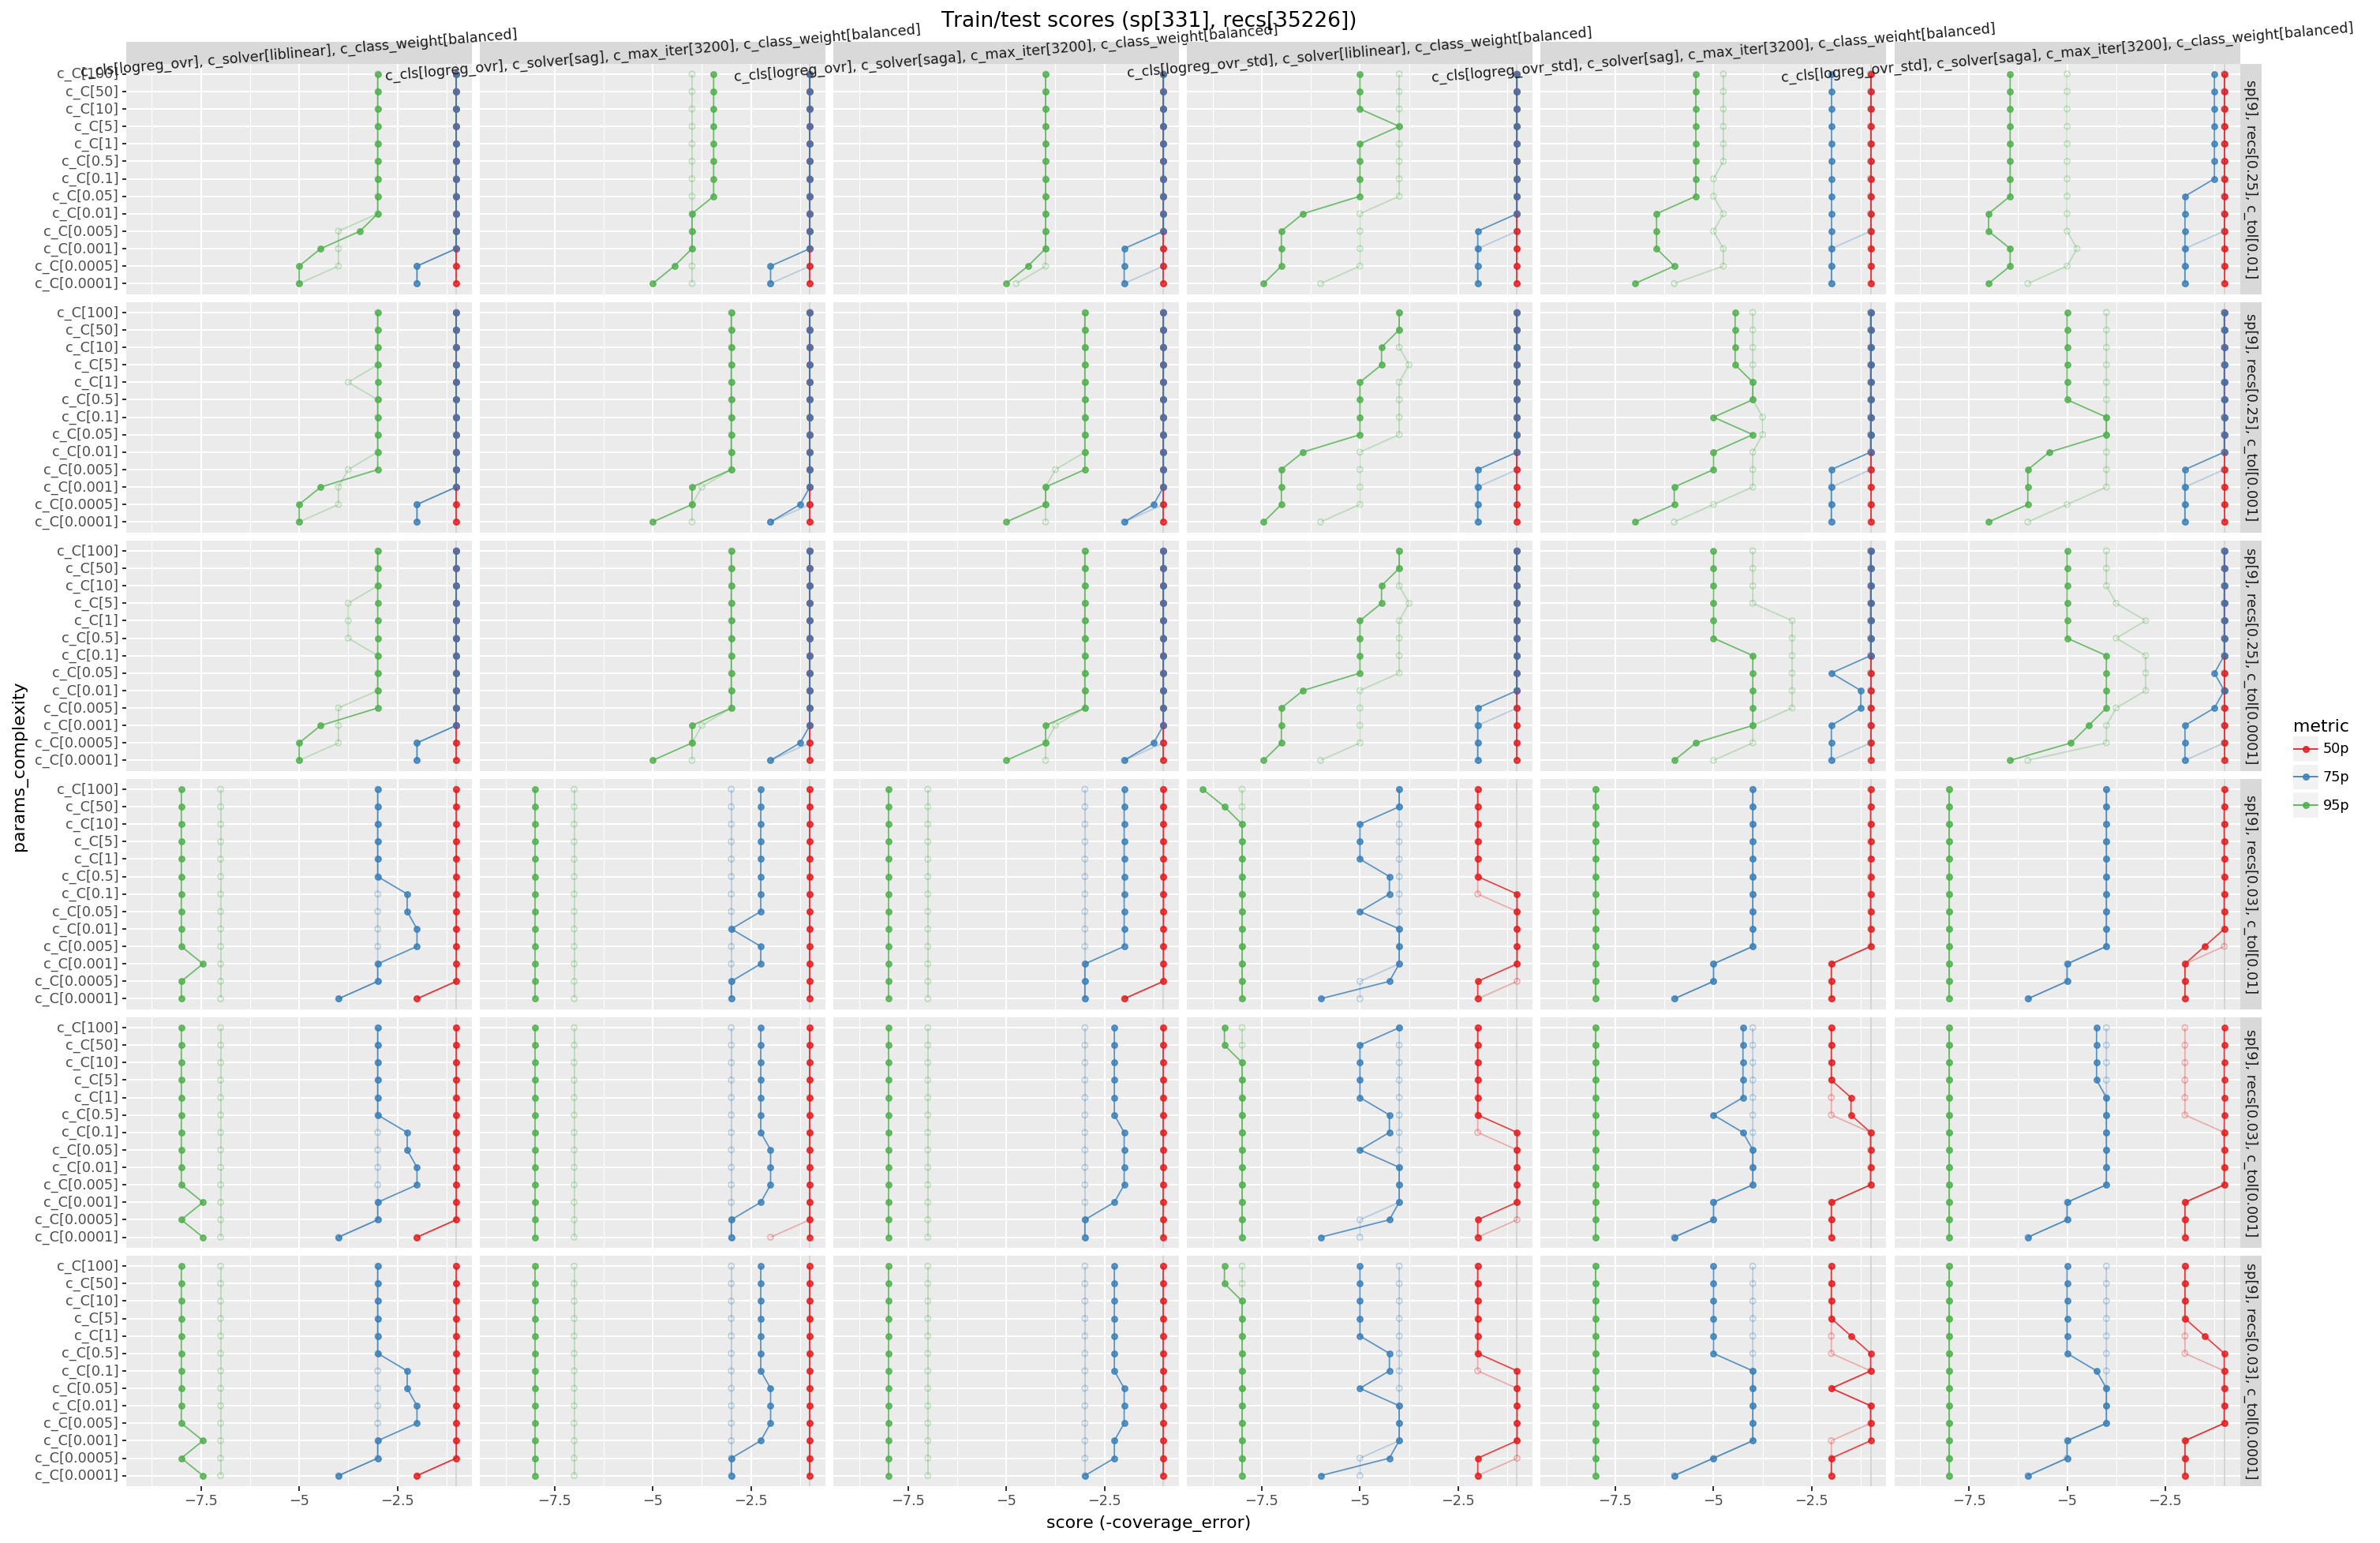

<ggplot: (-9223363244005213752)>

In [ ]:
# Train/test scores
#   - Grain: models x {train,test}
#   - Metrics: score
#   - Dims: group, params
metrics = [
    'train_50p_score', 'test_50p_score',
    'train_75p_score', 'test_75p_score',
    'train_95p_score', 'test_95p_score',
]
(cv_models
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(lambda df: pd.melt(df,
        id_vars=[
            'params', 'params_data', 'params_model', 'params_complexity',
            'params_data_and_model', 'params_model_and_complexity',
            'n_species', 'n_recs',
            'fold',
        ],
        value_vars=metrics,
        var_name='split_metric',
        value_name='score'),
    )
    .assign(
        split_metric=lambda df: df.split_metric.str.replace('_score', ''),
        split=lambda df: df.split_metric.str.split('_').str[0],
        metric=lambda df: df.split_metric.str.split('_').str[1],
        group=lambda df: df.params_complexity.str.cat(df.split_metric, '/'),
    )
    .pipe(df_ordered_cat,
        split_metric=[strip_endswith(x, '_score') for x in metrics],
        group=lambda df: reversed(df.group.unique()),
    )
    .pipe(lambda df: (df
        .pipe(ggplot)
        + aes(x='params_complexity')
        + aes(y='score')
        + aes(color='metric')
        + facet + theme_
        + geom_hline(yintercept=-1, color='lightgrey')  # -1 is the max score (1 is the min coverage_error)
        + geom_point(df[df.split == 'train'], alpha=.3, fill='none')
        + geom_point(df[df.split == 'test'], alpha=.8)
        + geom_line(df[df.split == 'train'], alpha=.3, mapping=aes(group='split_metric', color='metric'))
        + geom_line(df[df.split == 'test'], alpha=.8, mapping=aes(group='split_metric', color='metric'))
        # TODO How to manually add a legend that shows test:filled, train:unfilled?
        # + geom_jitter(fill='none', size=3, height=1e-9, width=.05)
        # + geom_count(aes(size='..n..')) + scale_size_area()
        # + stat_summary(aes(group='group'), fun_data='mean_cl_boot', random_state=0, geom='errorbar')
        + coord_flip(
            # ylim=(-40, 0),
            # ylim=(-10, 0),
        )
        + scale_color_cmap_d('Set1')
        + theme_figsize(width=12*2, aspect_ratio=1/1.5)
        + ylab('score (-coverage_error)')
        + ggtitle(f'Train/test scores ({recs_stats})')
    ))
)

In [ ]:
(cv_models
    .pipe(ggplot)
    + aes(x='cpu_time_m')
    + aes(color='params_complexity')
    + facet + theme_
    + geom_line(aes(y='train_75p_score'), alpha=.3, color='darkgray')
    + geom_line(aes(y='test_75p_score'), alpha=.8, color='darkgray')
    + geom_point(aes(y='train_75p_score'), alpha=.3, fill='none')
    + geom_point(aes(y='test_75p_score'), alpha=.8)
    + geom_hline(yintercept=0, color='grey')
    + expand_limits(x=0)
    + coord_flip(
        # + ylim(-30, 0)
    )
    + scale_color_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + guides(color=guide_legend(ncol=1)) + theme(legend_position='right', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize(width=12*2, aspect_ratio=1/1.5)
    + ggtitle('75p_score ~ cpu_time_m')
)

[skip]

In [ ]:
(cv_models
    .pipe(ggplot)
    + aes(x='model_size')
    + aes(color='params_complexity')
    + facet + theme_
    + geom_line(aes(y='train_75p_score'), alpha=.3, color='darkgray')
    + geom_line(aes(y='test_75p_score'), alpha=.8, color='darkgray')
    + geom_point(aes(y='train_75p_score'), alpha=.3, fill='none')
    + geom_point(aes(y='test_75p_score'), alpha=.8)
    + geom_hline(yintercept=0, color='grey')
    + scale_x_continuous(labels=labels_bytes(), breaks=breaks_bytes())
    + expand_limits(x=0)
    + coord_flip(
        # + ylim(-30, 0)
    )
    + scale_color_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + guides(color=guide_legend(ncol=1)) + theme(legend_position='right', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize(width=12*2, aspect_ratio=1/1.5)
    + ggtitle('test_75p_score ~ model_size')
)

[skip]

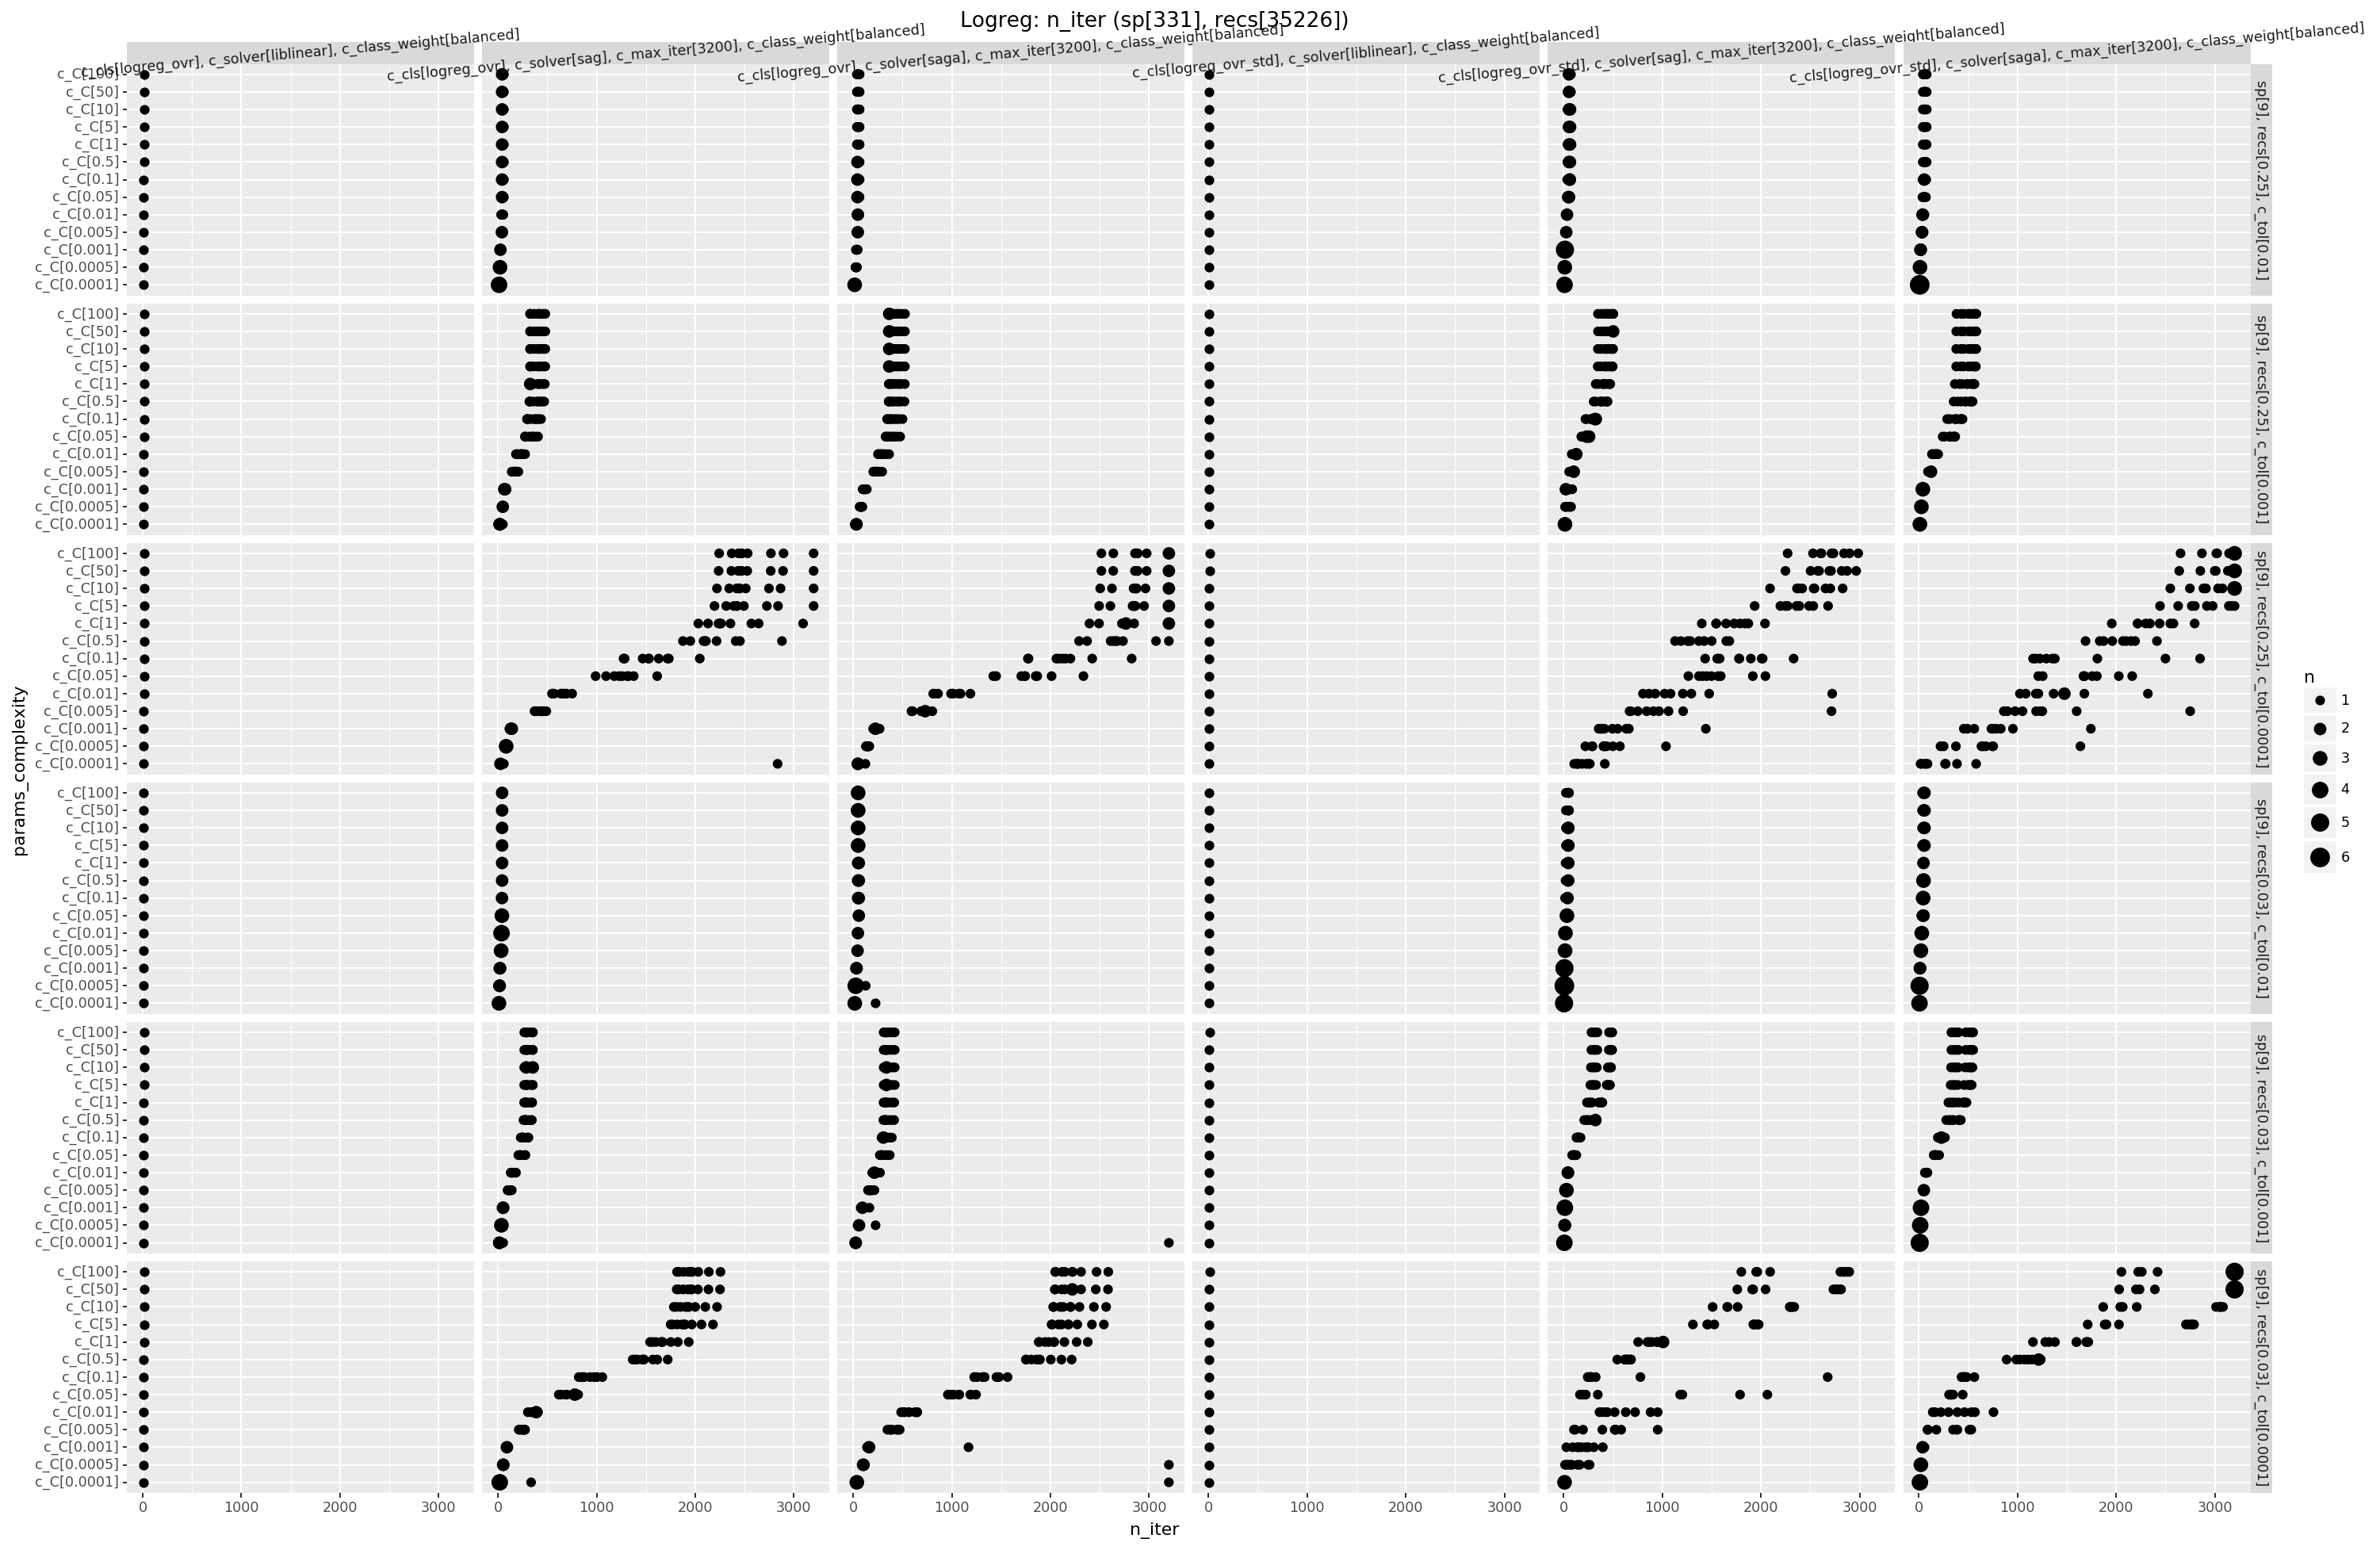

<ggplot: (8792862454031)>

In [ ]:
# Tune logreg n_iter
(cv_models
    .merge(how='left', on='model_id', right=df_flatmap(cv_models, lambda row: (
        dict(model_id=row.model_id, n_iter=n_iter)
        for n_iter in coalesce(row.n_iters, [0])
    )))
    # Manually compute y.mean() per group
    # .groupby('params').apply(lambda g: g.assign(cpu_time_m_mean=lambda df: df.cpu_time_m.mean()))
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + aes(x='params_complexity')
    + facet + theme_
    + geom_count(aes(y='n_iter', size='..n..')) + scale_size_area()
    + expand_limits(y=0)
    + coord_flip(
        # ylim=(0, 100),  # TODO TODO XXX
    )
    + theme_figsize(width=12*2, aspect_ratio=1/1.5)
    + ggtitle(f'Logreg: n_iter ({recs_stats})')
)

In [ ]:
# Train time ~ n_species
(cv_models
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + facet_grid('n_recs ~ params_model')
    + aes(color='params_complexity')
    + aes(x='n_species', y='cpu_time_m')
    + geom_point()
    + geom_line()
    + scale_color_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + guides(color=guide_legend(ncol=1)) + theme(legend_position='right', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize(width=12*2, aspect_ratio=1/1.5)
    + ggtitle(f'Train time ~ n_species ({recs_stats})')
)

[skip]

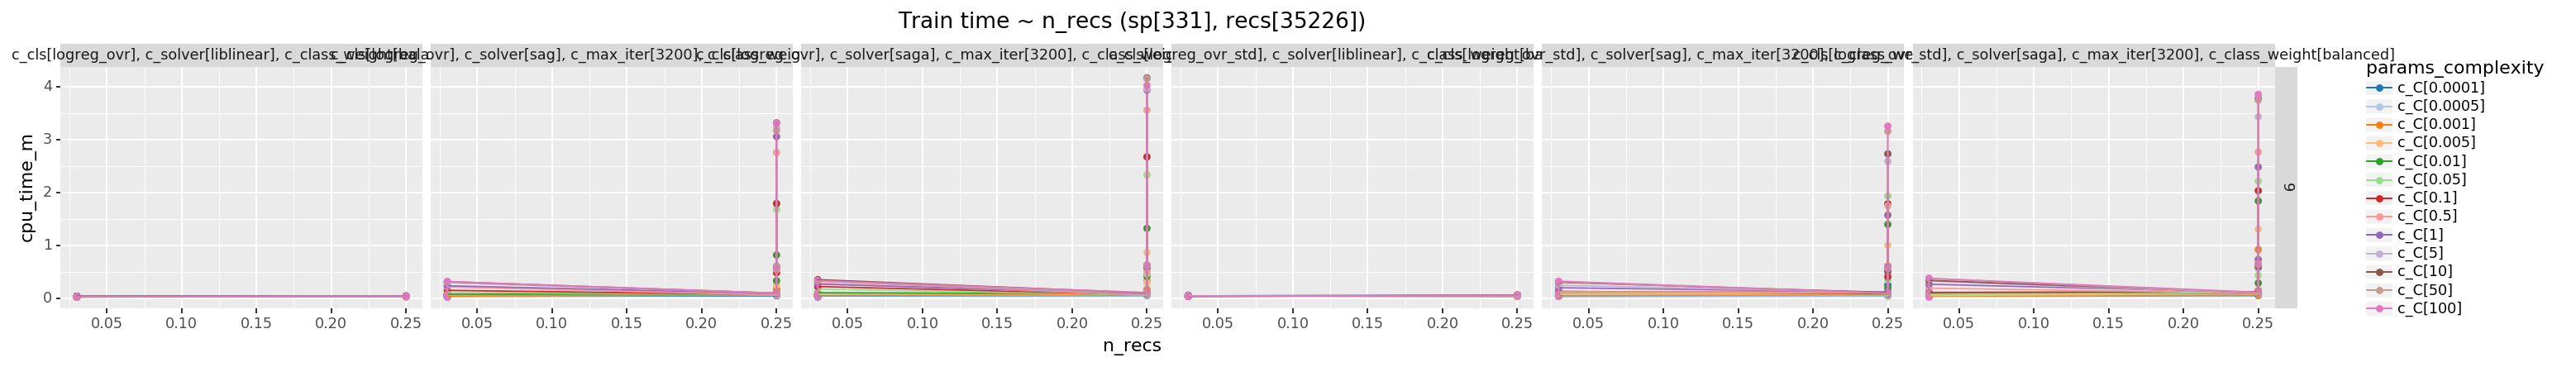

<ggplot: (-9223363244015744417)>

In [ ]:
# Train time ~ n_recs
(cv_models
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + facet_grid('n_species ~ params_model')
    + aes(color='params_complexity')
    + aes(x='n_recs', y='cpu_time_m')
    + geom_point()
    + geom_line()
    + scale_color_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + guides(color=guide_legend(ncol=1)) + theme(legend_position='right', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize(width=12*2, aspect_ratio=1/1.5)
    + ggtitle(f'Train time ~ n_recs ({recs_stats})')
)

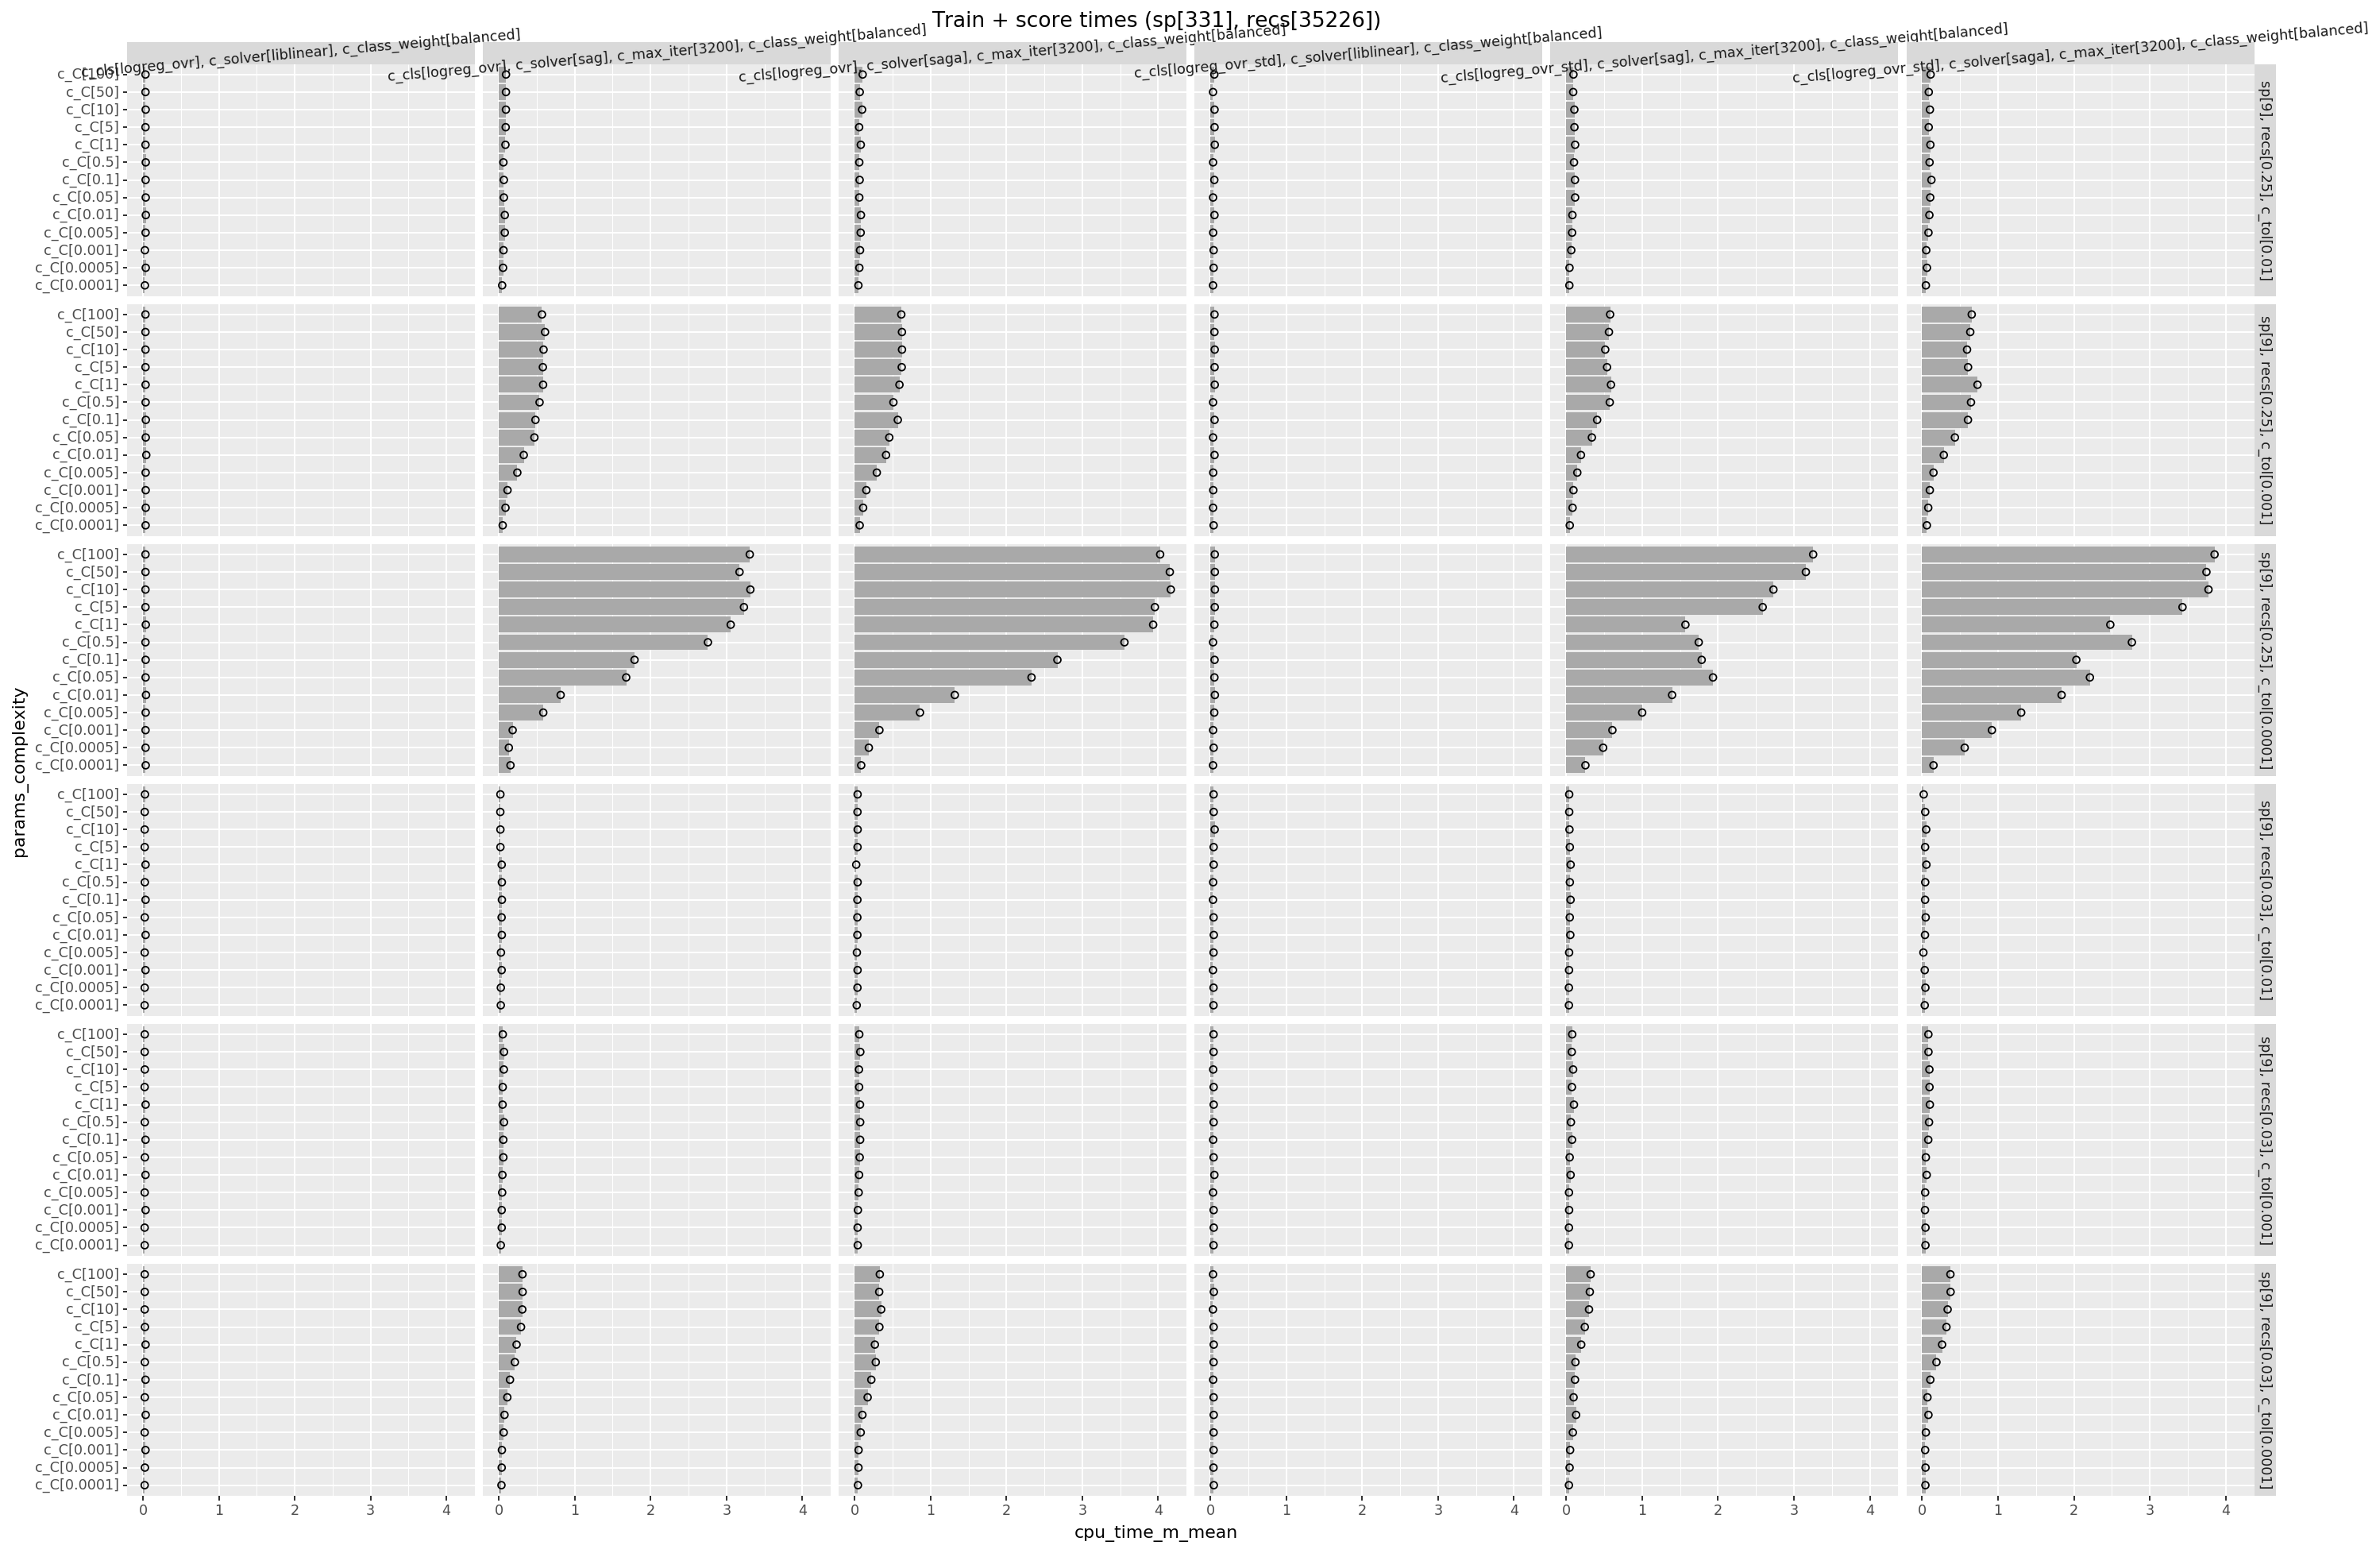

<ggplot: (8792841792888)>

In [ ]:
(cv_models
    # Manually compute y.mean() per group
    .groupby('params').apply(lambda g: g.assign(cpu_time_m_mean=lambda df: df.cpu_time_m.mean()))
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + aes(x='params_complexity')
    + facet + theme_
    + geom_col(aes(y='cpu_time_m_mean'), fill='darkgray', position=position_dodge())
    + geom_point(aes(y='cpu_time_m'), color='black', fill='none', size=2)
    + coord_flip(
        # ylim=(0, 10),  # TODO TODO XXX
        # ylim=(0, 4),  # TODO TODO XXX
    )
    + theme_figsize(width=12*2, aspect_ratio=1/1.5)
    + ggtitle(f'Train + score times ({recs_stats})')
)

In [ ]:
(cv_models
    # Manually compute y.mean() per group
    .groupby('params').apply(lambda g: g.assign(model_size_mean=lambda df: df.model_size.mean()))
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + aes(x='params_complexity')
    + facet + theme_
    + geom_col(aes(y='model_size_mean'), fill='darkgray', position=position_dodge()) # Summary per fold
    + geom_point(aes(y='model_size'), color='black', fill='none', size=2) # Distribution of folds
    + scale_y_continuous(labels=labels_bytes(), breaks=breaks_bytes())
    + coord_flip()
    + ylab('model_size')
    + theme_figsize(width=12*2, aspect_ratio=1/1.5)
    + ggtitle(f'Model size ({recs_stats})')
)

[skip]

In [ ]:
# TODO Make not barf on non-tree models (blocks rest of notebook)
(cv_models
    # Manually compute boxplot stats, else it's _really_ slow (or you have to downsample, which misses outliers)
    #   - Based on stat_boxplot.compute_group
    .merge(how='left', on='params', right=cv_models.groupby('params').apply(lambda g: one(
        pd.Series(dict(
            params=g.name,
            ymin=boxplot['whislo'],
            lower=boxplot['q1'],
            middle=boxplot['med'],
            upper=boxplot['q3'],
            ymax=boxplot['whishi'],
            outliers=np.unique(boxplot['fliers']),  # np.unique else really slow, because lots of repeated (int) points
        ))
        for [boxplot] in [mpl.cbook.boxplot_stats(  # [boxplot] is 1 elem because X.ndim = 1
            X=np.concatenate([coalesce(x, {}).get('depth', []) for x in g.model_stats]),
            whis=1.5,
        )]
    )))
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + aes(x='params_complexity')
    + facet + theme_
    + geom_boxplot(
        stat='identity',
        outlier_size=.5,
        mapping=aes(ymin='ymin', ymax='ymax', upper='upper', lower='lower', middle='middle', outliers='outliers',
            width=.8,  # Close enough to geom_boxplot defaults [TODO Maybe should compute based on num categorical x's?]
        ),
    )
    + ylab('tree_depth')
    + coord_flip()
    + theme_figsize(width=12*2, aspect_ratio=1/1.5)
    + ggtitle(f'Tree depth ({recs_stats})')
)

[skip]